In [1]:
# ! pip install numpy==1.19.5
import os
import gym
import time
import keras
import random
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import deque, defaultdict
from keras.models import Model, save_model, load_model
from keras.models import Sequential
from keras.layers import Input, Dense, Flatten, Dropout
from keras.utils.layer_utils import count_params

%matplotlib inline


In [2]:
env = gym.make("LunarLanderContinuous-v2")

#### Lunar Lander Continous

Landing pad is always at coordinates (0,0). Coordinates are the first two numbers in state vector. Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points. If lander moves away from landing pad it loses reward back. Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points. Each leg ground contact is +10. Firing main engine is -0.3 points each frame. Solved is 200 points. Landing outside landing pad is possible. Fuel is infinite, so an agent can learn to fly and then land on its first attempt. Four discrete actions available: do nothing, fire left orientation engine, fire main engine, fire right orientation engine.

In [3]:
# print out base information about the environment
n_states = env.observation_space.shape[0]
print('State Space Size', n_states)
n_actions = env.action_space.shape[0]
print('Action Space Size', n_actions)

upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]

print('Max Value of Action:', upper_bound)
print('Min Value of Action:', lower_bound)

State Space Size 8
Action Space Size 2
Max Value of Action: 1.0
Min Value of Action: -1.0


In [4]:
# create actor model
def create_actor_model(inputs=n_states, learning_rate=0.01):
    actor_model = Sequential()
    actor_model.add(Input(shape=(inputs,)))
    actor_model.add(Dense(512, activation='relu'))
    actor_model.add(Dense(256, activation='relu'))
    actor_model.add(Dense(2, activation='tanh', kernel_initializer=tf.random_uniform_initializer(minval=-0.05, maxval=0.05)))
    # ADAM optimiser
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    actor_model.compile(optimizer=opt)
    return actor_model

In [5]:
# create critic model
def create_critic_model(inputs=n_states+n_actions, learning_rate=0.01):
    critic_model = Sequential()
    critic_model.add(Input(shape=(inputs,)))
    critic_model.add(Dense(512, activation='relu'))
    critic_model.add(Dense(256, activation='relu'))
    critic_model.add(Dense(1, activation='linear'))
    # ADAM optimiser
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    critic_model.compile(optimizer=opt)
    return critic_model

In [6]:
# FileLogger class adapted from the lunarlander dqn notebook
class FileLogger():
    def __init__(self, file_name='logs/ddpg_progress.log'):
        self.file_name = file_name
        self.clean_progress_file()

    def log(self, episode, reward, average_reward):
        with open(self.file_name, 'a+') as f:
            f.write(f"{episode};{reward};{average_reward}\n")

    
    def clean_progress_file(self):
        if os.path.exists(self.file_name):
            os.remove(self.file_name)
        with open(self.file_name, 'a+') as f:
            f.write("episode;reward;average\n")

# define function to select action with Gaussian noise
def select_action(state, env, actor_network):
    upper_bound = env.action_space.high[0]
    lower_bound = env.action_space.low[0]
    actions = actor_network.predict(np.reshape(state, (1, env.observation_space.shape[0])))
#     adding noise with Gaussian distribution
    actions += np.random.normal(loc=0.0, scale=0.2, size=[n_actions])
    actions = tf.clip_by_value(actions, lower_bound, upper_bound)
    return actions[0]

# function to update target networks
@tf.function
def update_target_weights(target_actor, actor, target_critic, critic):
    tau = 0.05
    actor_weights = actor.weights
    target_actor_weights = target_actor.weights
    for index in range(len(actor_weights)):
        target_actor_weights[index] = tau * actor_weights[index] + (1 - tau) * target_actor_weights[index]
    target_actor.set_weights(target_actor_weights)
    
    critic_weights = critic.weights
    target_critic_weights = target_critic.weights
    for index in range(len(critic_weights)):
        target_critic_weights[index] = tau * critic_weights[index] + (1 - tau) * target_critic_weights[index]
    target_critic.set_weights(target_critic_weights)

@tf.function
def update(gamma, states, actions, rewards, next_states, terminal_states, target_actor_network, actor_network, target_critic_network, critic_network):
    terminal_states = tf.cast(terminal_states, tf.float32)
    with tf.GradientTape() as tape:
        target_actions = target_actor_network(next_states, training=True)
        target_values = tf.squeeze(target_critic_network(tf.concat(values=[next_states, target_actions], axis=1)), 1)
        target = rewards + gamma * target_values * ((tf.ones(shape=(terminal_states.shape), dtype=tf.float32)) - terminal_states)
        q_value = tf.squeeze(critic_network(tf.concat(values=[states, actions], axis=1), training=True), 1)
        critic_loss = tf.keras.losses.MSE(target, q_value)

    critic_grads = tape.gradient(critic_loss, critic_network.trainable_variables)
    critic_network.optimizer.apply_gradients(zip(critic_grads, critic_network.trainable_variables))

    with tf.GradientTape() as tape:
        actions = actor_network(states, training=True)
        critic_value = - critic_network(tf.concat(values=[states, actions], axis=1), training=True)
        actor_loss = tf.math.reduce_mean(critic_value)

    actor_grad = tape.gradient(actor_loss, actor_network.trainable_variables)
    actor_network.optimizer.apply_gradients(zip(actor_grad, actor_network.trainable_variables))


In [7]:
# ddpg train function
def ddpg(
    env,
    max_exp_replay=100_000,
    gamma=0.99,
    alpha=0.001,
    beta=0.002,
    update_target=10,
    n_episodes=1000,
    max_episode_steps=1_000,
    batchsize=64
):
    replay_buffer = deque(maxlen=max_exp_replay)
    best_score = env.reward_range[0]
    score_history = []
    model_dir = './model'
    file_logger = FileLogger()

    my_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(model_dir, 'model.{epoch:02d}-{loss:.2f}.h5'),
                                       save_freq=1024),
    tf.keras.callbacks.TensorBoard(log_dir='./logs')]
    
#     initialize actor networks
    actor_network = create_actor_model(learning_rate=alpha)
    target_actor_network = create_actor_model(learning_rate=alpha)
#     set weights as as in actor network
    target_actor_network.set_weights(actor_network.get_weights())
#     initialize critic networks
    critic_network = create_critic_model(learning_rate=beta)
    target_critic_network = create_critic_model(learning_rate=beta)
#     set weights as in critic network
    target_critic_network.set_weights(critic_network.get_weights())
    
    random.seed(42)
    start = time.time()
    for episode in tqdm(range(1, n_episodes + 1), ascii=True, unit='episodes'):
        print('episode', episode)
        done = False
        state = env.reset()
        ep_reward = 0
        while not done:
            action = select_action(state, env, actor_network)
            next_state, reward, done, _ = env.step(action)
            replay_buffer.append((np.reshape(state, (n_states)),
                                  np.reshape(action, (n_actions)), reward,
                                  np.reshape(next_state, (n_states)), done))
            ep_reward += reward           
            if ep_reward > best_score:
                best_score = ep_reward
            if len(replay_buffer) < batchsize:
                continue
            batch = random.sample(replay_buffer, batchsize)
            states = tf.convert_to_tensor([transition[0] for transition in batch])
            actions = tf.convert_to_tensor([transition[1] for transition in batch])
            rewards = tf.convert_to_tensor([transition[2] for transition in batch])
            rewards = tf.cast(rewards, dtype=tf.float32)
            next_states = tf.convert_to_tensor([transition[3] for transition in batch])
            terminal_states = tf.convert_to_tensor([transition[4] for transition in batch])
            update(gamma, states, actions, rewards, next_states, terminal_states, target_actor_network, actor_network, target_critic_network, critic_network)
                
            update_target_weights(target_actor=target_actor_network,
                                  actor=actor_network,
                                  target_critic=target_critic_network,
                                  critic=critic_network)    
            if done:
                break
            state = next_state
        print(ep_reward)
        score_history.append(ep_reward)
        avg_score = np.mean(score_history[-100:])
        file_logger.log(episode, ep_reward, avg_score)
#         if ep_reward >= 200:
#             actor_network.save(os.path.join(model_dir, 'actor200.h5')) 
#             break
    critic_network.save(os.path.join(model_dir, 'critic.h5'))
    actor_network.save(os.path.join(model_dir, 'ddpg_model.h5'))
    # save_model(actor_network, 'actor_model.h5')
    end = time.time()
    try:
        with open('logs/rewards_history.pickle','wb') as f: pickle.dump(score_history, f)
    except:
        pass
    try:
        with open('logs/average_scores.pickle','wb') as f: pickle.dump(avg_score, f)
    except:
        pass
    print('Total time passed:', end - start,  'seconds')
    
    return score_history, actor_network

In [8]:
tf.config.run_functions_eagerly(True)
env = gym.make("LunarLanderContinuous-v2")
scores, model = ddpg(env)

  0%|          | 0/1000 [00:00<?, ?episodes/s]/anaconda/envs/azureml_py38/lib/python3.8/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


episode 1



  0%|          | 1/1000 [00:08<2:20:54,  8.46s/episodes]

-316.00783509681924
episode 2



  0%|          | 2/1000 [00:13<1:43:38,  6.23s/episodes]

-348.8384126126766
episode 3



  0%|          | 3/1000 [00:19<1:45:35,  6.35s/episodes]

-499.6546195211568
episode 4



  0%|          | 4/1000 [00:35<2:44:49,  9.93s/episodes]

-333.15252197188534
episode 5



  0%|          | 5/1000 [01:16<5:55:00, 21.41s/episodes]

-226.43592754083795
episode 6



  1%|          | 6/1000 [01:28<4:58:30, 18.02s/episodes]

-241.8904833136507
episode 7



  1%|          | 7/1000 [01:33<3:46:47, 13.70s/episodes]

-222.87585364524443
episode 8



  1%|          | 8/1000 [02:00<5:01:24, 18.23s/episodes]

-283.97234050166094
episode 9



  1%|          | 9/1000 [02:24<5:30:01, 19.98s/episodes]

247.77078854308905
episode 10



  1%|1         | 10/1000 [02:32<4:26:05, 16.13s/episodes]

-303.68544927658013
episode 11



  1%|1         | 11/1000 [02:42<3:57:16, 14.39s/episodes]

-305.5848254883299
episode 12



  1%|1         | 12/1000 [03:06<4:44:14, 17.26s/episodes]

-549.3481695357642
episode 13



  1%|1         | 13/1000 [03:24<4:44:51, 17.32s/episodes]

-121.80105753035924
episode 14



  1%|1         | 14/1000 [03:50<5:28:38, 20.00s/episodes]

-256.38484059431846
episode 15



  2%|1         | 15/1000 [04:07<5:12:45, 19.05s/episodes]

-114.12598301312795
episode 16



  2%|1         | 16/1000 [04:31<5:40:43, 20.78s/episodes]

-269.0912956248727
episode 17



  2%|1         | 17/1000 [04:48<5:18:49, 19.46s/episodes]

-20.308612424166682
episode 18



  2%|1         | 18/1000 [05:25<6:45:45, 24.79s/episodes]

-277.7091432537776
episode 19



  2%|1         | 19/1000 [06:47<11:26:55, 42.01s/episodes]

-183.16608600044606
episode 20



  2%|2         | 20/1000 [07:16<10:23:44, 38.19s/episodes]

-258.7013455504736
episode 21



  2%|2         | 21/1000 [07:40<9:11:55, 33.83s/episodes] 

-216.97604741959265
episode 22



  2%|2         | 22/1000 [07:49<7:07:29, 26.23s/episodes]

-75.2222865616873
episode 23



  2%|2         | 23/1000 [08:00<5:56:20, 21.88s/episodes]

-90.84972914854458
episode 24



  2%|2         | 24/1000 [08:07<4:41:11, 17.29s/episodes]

-201.671898183203
episode 25



  2%|2         | 25/1000 [08:42<6:09:15, 22.72s/episodes]

-253.47078159372313
episode 26



  3%|2         | 26/1000 [09:20<7:19:55, 27.10s/episodes]

-198.4887164288729
episode 27



  3%|2         | 27/1000 [10:09<9:09:06, 33.86s/episodes]

-364.7276196113291
episode 28



  3%|2         | 28/1000 [10:29<7:58:48, 29.56s/episodes]

-471.2457517420084
episode 29



  3%|2         | 29/1000 [11:47<11:54:59, 44.18s/episodes]

-317.07765350740874
episode 30



  3%|3         | 30/1000 [12:11<10:16:06, 38.11s/episodes]

-236.260757331544
episode 31



  3%|3         | 31/1000 [12:23<8:08:10, 30.23s/episodes] 

-188.7096720037507
episode 32



  3%|3         | 32/1000 [12:50<7:50:44, 29.18s/episodes]

-431.1747280275527
episode 33



  3%|3         | 33/1000 [13:04<6:36:53, 24.63s/episodes]

-183.8129232149373
episode 34



  3%|3         | 34/1000 [13:13<5:24:49, 20.18s/episodes]

-145.5284604493844
episode 35



  4%|3         | 35/1000 [13:40<5:55:19, 22.09s/episodes]

-127.30921289556167
episode 36



  4%|3         | 36/1000 [14:06<6:16:03, 23.41s/episodes]

-216.66150380378267
episode 37



  4%|3         | 37/1000 [15:18<10:06:06, 37.76s/episodes]

-292.5706901093399
episode 38



  4%|3         | 38/1000 [15:31<8:08:11, 30.45s/episodes] 

-296.87447130336875
episode 39



  4%|3         | 39/1000 [16:44<11:33:01, 43.27s/episodes]

147.4516561627085
episode 40



  4%|4         | 40/1000 [18:15<15:19:24, 57.46s/episodes]

-96.0517410645519
episode 41



  4%|4         | 41/1000 [18:21<11:12:00, 42.04s/episodes]

-21.515345020471244
episode 42



  4%|4         | 42/1000 [19:51<15:01:20, 56.45s/episodes]

-72.04225521129229
episode 43



  4%|4         | 43/1000 [21:23<17:52:17, 67.23s/episodes]

-42.442120432902954
episode 44



  4%|4         | 44/1000 [22:26<17:31:32, 66.00s/episodes]

-230.8292983276104
episode 45



  4%|4         | 45/1000 [23:58<19:32:12, 73.65s/episodes]

19.617212494632255
episode 46



  5%|4         | 46/1000 [25:26<20:40:17, 78.01s/episodes]

147.37377036161303
episode 47



  5%|4         | 47/1000 [26:49<21:00:20, 79.35s/episodes]

-35.145732583452016
episode 48



  5%|4         | 48/1000 [27:43<18:59:44, 71.83s/episodes]

214.09057599456378
episode 49



  5%|4         | 49/1000 [29:13<20:25:14, 77.30s/episodes]

-17.065805438047196
episode 50



  5%|5         | 50/1000 [30:06<18:31:00, 70.17s/episodes]

210.65122280644087
episode 51



  5%|5         | 51/1000 [31:08<17:47:06, 67.47s/episodes]

-179.08659215936743
episode 52



  5%|5         | 52/1000 [31:32<14:21:51, 54.55s/episodes]

-243.6108750030376
episode 53



  5%|5         | 53/1000 [31:41<10:46:27, 40.96s/episodes]

-56.569410558222046
episode 54



  5%|5         | 54/1000 [31:55<8:39:08, 32.93s/episodes] 

-217.51556934913094
episode 55



  6%|5         | 55/1000 [32:50<10:20:20, 39.39s/episodes]

-566.2754182599818
episode 56



  6%|5         | 56/1000 [34:01<12:47:51, 48.80s/episodes]

-394.48796639228806
episode 57



  6%|5         | 57/1000 [34:52<12:56:29, 49.41s/episodes]

-263.5230311553281
episode 58



  6%|5         | 58/1000 [36:22<16:08:17, 61.67s/episodes]

-72.24097736389311
episode 59



  6%|5         | 59/1000 [37:53<18:24:21, 70.42s/episodes]

-105.27495445284634
episode 60



  6%|6         | 60/1000 [38:24<15:20:41, 58.77s/episodes]

-485.8066489757397
episode 61



  6%|6         | 61/1000 [38:53<12:59:24, 49.80s/episodes]

-351.4666699665555
episode 62



  6%|6         | 62/1000 [39:13<10:36:50, 40.74s/episodes]

-186.71206525101326
episode 63



  6%|6         | 63/1000 [39:42<9:43:05, 37.34s/episodes] 

-636.1888902206217
episode 64



  6%|6         | 64/1000 [40:07<8:42:28, 33.49s/episodes]

-572.4082015571713
episode 65



  6%|6         | 65/1000 [40:34<8:11:47, 31.56s/episodes]

-590.75955052294
episode 66



  7%|6         | 66/1000 [41:01<7:49:58, 30.19s/episodes]

-517.0027594926044
episode 67



  7%|6         | 67/1000 [41:46<8:59:43, 34.71s/episodes]

-802.3760985474346
episode 68



  7%|6         | 68/1000 [42:20<8:56:36, 34.55s/episodes]

-514.5793886716347
episode 69



  7%|6         | 69/1000 [43:13<10:20:03, 39.96s/episodes]

-564.1894331821732
episode 70



  7%|7         | 70/1000 [43:30<8:35:32, 33.26s/episodes] 

-47.01006526816562
episode 71



  7%|7         | 71/1000 [45:04<13:14:17, 51.30s/episodes]

-210.58246294560843
episode 72



  7%|7         | 72/1000 [45:24<10:50:04, 42.03s/episodes]

-168.6944294253592
episode 73



  7%|7         | 73/1000 [45:32<8:11:06, 31.79s/episodes] 

-18.837931947548853
episode 74



  7%|7         | 74/1000 [45:54<7:24:54, 28.83s/episodes]

-134.2386319609464
episode 75



  8%|7         | 75/1000 [47:27<12:22:33, 48.17s/episodes]

-118.41775192144624
episode 76



  8%|7         | 76/1000 [48:17<12:30:16, 48.72s/episodes]

-212.74328341818216
episode 77



  8%|7         | 77/1000 [49:51<15:56:03, 62.15s/episodes]

-23.45531076507242
episode 78



  8%|7         | 78/1000 [50:21<13:26:39, 52.49s/episodes]

-187.85536001849482
episode 79



  8%|7         | 79/1000 [50:33<10:23:07, 40.59s/episodes]

-194.47773656796952
episode 80



  8%|8         | 80/1000 [51:54<13:24:36, 52.47s/episodes]

-423.11227807786406
episode 81



  8%|8         | 81/1000 [52:47<13:26:30, 52.66s/episodes]

-299.52525766857445
episode 82



  8%|8         | 82/1000 [54:19<16:26:17, 64.46s/episodes]

-28.117502236307082
episode 83



  8%|8         | 83/1000 [54:24<11:55:20, 46.81s/episodes]

-521.8030127624512
episode 84



  8%|8         | 84/1000 [55:56<15:21:54, 60.39s/episodes]

-161.9949872478401
episode 85



  8%|8         | 85/1000 [57:29<17:47:45, 70.02s/episodes]

-80.87362416618107
episode 86



  9%|8         | 86/1000 [58:24<16:37:16, 65.47s/episodes]

-348.0381581479262
episode 87



  9%|8         | 87/1000 [58:34<12:24:10, 48.91s/episodes]

-182.79143270466767
episode 88



  9%|8         | 88/1000 [59:19<12:05:39, 47.74s/episodes]

-45.78426847309439
episode 89



  9%|8         | 89/1000 [59:29<9:12:23, 36.38s/episodes] 

-20.017364214300386
episode 90



  9%|9         | 90/1000 [59:56<8:30:22, 33.65s/episodes]

-214.37156702613683
episode 91



  9%|9         | 91/1000 [1:00:37<9:01:36, 35.75s/episodes]

-191.24307280228595
episode 92



  9%|9         | 92/1000 [1:00:48<7:09:54, 28.41s/episodes]

-106.92525849968678
episode 93



  9%|9         | 93/1000 [1:01:42<9:04:18, 36.01s/episodes]

-233.9731313962517
episode 94



  9%|9         | 94/1000 [1:02:00<7:40:41, 30.51s/episodes]

-88.19812997332605
episode 95



 10%|9         | 95/1000 [1:02:21<6:57:46, 27.70s/episodes]

-114.94418274423326
episode 96



 10%|9         | 96/1000 [1:03:52<11:45:48, 46.85s/episodes]

-67.87597440864732
episode 97



 10%|9         | 97/1000 [1:04:38<11:42:10, 46.66s/episodes]

-323.63105878756903
episode 98



 10%|9         | 98/1000 [1:04:57<9:33:18, 38.14s/episodes] 

-43.198462219913964
episode 99



 10%|9         | 99/1000 [1:05:15<8:03:11, 32.18s/episodes]

-204.72372571043903
episode 100



 10%|#         | 100/1000 [1:05:29<6:40:40, 26.71s/episodes]

-318.1946702881878
episode 101



 10%|#         | 101/1000 [1:05:38<5:20:04, 21.36s/episodes]

-279.95912326000064
episode 102



 10%|#         | 102/1000 [1:05:57<5:09:22, 20.67s/episodes]

0.55313486947081
episode 103



 10%|#         | 103/1000 [1:06:10<4:35:59, 18.46s/episodes]

-133.30552821227684
episode 104



 10%|#         | 104/1000 [1:06:31<4:44:43, 19.07s/episodes]

-19.15202394836561
episode 105



 10%|#         | 105/1000 [1:07:00<5:28:59, 22.06s/episodes]

-95.71356074717086
episode 106



 11%|#         | 106/1000 [1:07:54<7:52:58, 31.74s/episodes]

-129.37748991910897
episode 107



 11%|#         | 107/1000 [1:08:44<9:14:54, 37.28s/episodes]

-319.00862652440935
episode 108



 11%|#         | 108/1000 [1:10:17<13:23:16, 54.03s/episodes]

59.49947086595936
episode 109



 11%|#         | 109/1000 [1:11:07<13:01:31, 52.63s/episodes]

-252.36792169826066
episode 110



 11%|#1        | 110/1000 [1:11:30<10:50:47, 43.87s/episodes]

-371.15720840407994
episode 111



 11%|#1        | 111/1000 [1:12:03<9:59:21, 40.45s/episodes] 

-50.575742470133726
episode 112



 11%|#1        | 112/1000 [1:12:40<9:43:19, 39.41s/episodes]

270.03084953198413
episode 113



 11%|#1        | 113/1000 [1:13:56<12:25:29, 50.43s/episodes]

155.39473985789272
episode 114



 11%|#1        | 114/1000 [1:15:27<15:23:54, 62.57s/episodes]

-56.64735519041865
episode 115



 12%|#1        | 115/1000 [1:16:58<17:28:41, 71.10s/episodes]

-6.110216419398501
episode 116



 12%|#1        | 116/1000 [1:18:28<18:52:28, 76.87s/episodes]

-7.077990192654021
episode 117



 12%|#1        | 117/1000 [1:19:58<19:47:45, 80.71s/episodes]

-112.89840869816761
episode 118



 12%|#1        | 118/1000 [1:21:29<20:31:53, 83.80s/episodes]

-92.97302626169038
episode 119



 12%|#1        | 119/1000 [1:22:59<20:57:23, 85.63s/episodes]

-96.88694704038157
episode 120



 12%|#2        | 120/1000 [1:24:28<21:12:32, 86.76s/episodes]

-58.27077569466582
episode 121



 12%|#2        | 121/1000 [1:25:49<20:47:04, 85.12s/episodes]

-104.20062284610698
episode 122



 12%|#2        | 122/1000 [1:27:20<21:09:41, 86.77s/episodes]

-35.37246247153844
episode 123



 12%|#2        | 123/1000 [1:28:51<21:27:29, 88.08s/episodes]

-111.26534041764064
episode 124



 12%|#2        | 124/1000 [1:29:28<17:42:56, 72.80s/episodes]

-289.21603726953026
episode 125



 12%|#2        | 125/1000 [1:29:38<13:05:05, 53.84s/episodes]

-57.807979573640395
episode 126



 13%|#2        | 126/1000 [1:30:34<13:12:45, 54.42s/episodes]

199.46223352410885
episode 127



 13%|#2        | 127/1000 [1:30:44<9:58:02, 41.10s/episodes] 

-87.04597843921579
episode 128



 13%|#2        | 128/1000 [1:32:14<13:31:58, 55.87s/episodes]

48.03819928790652
episode 129



 13%|#2        | 129/1000 [1:33:26<14:42:52, 60.82s/episodes]

-277.0549576835084
episode 130



 13%|#3        | 130/1000 [1:33:50<12:01:40, 49.77s/episodes]

276.39738958991916
episode 131



 13%|#3        | 131/1000 [1:35:20<14:54:14, 61.74s/episodes]

-65.649153949168
episode 132



 13%|#3        | 132/1000 [1:36:02<13:26:25, 55.74s/episodes]

-360.9121045710149
episode 133



 13%|#3        | 133/1000 [1:36:39<12:05:02, 50.18s/episodes]

-140.84804035859216
episode 134



 13%|#3        | 134/1000 [1:37:48<13:27:33, 55.95s/episodes]

-246.50934426285875
episode 135



 14%|#3        | 135/1000 [1:38:26<12:09:35, 50.61s/episodes]

251.05930865488065
episode 136



 14%|#3        | 136/1000 [1:39:56<14:57:33, 62.33s/episodes]

77.47668563049118
episode 137



 14%|#3        | 137/1000 [1:41:27<16:57:44, 70.76s/episodes]

-49.0134945394546
episode 138



 14%|#3        | 138/1000 [1:41:59<14:09:57, 59.16s/episodes]

-181.45590438594098
episode 139



 14%|#3        | 139/1000 [1:42:05<10:22:06, 43.35s/episodes]

-38.76207586796597
episode 140



 14%|#4        | 140/1000 [1:42:13<7:50:50, 32.85s/episodes] 

-70.44251799695243
episode 141



 14%|#4        | 141/1000 [1:43:26<10:41:33, 44.81s/episodes]

212.081029845701
episode 142



 14%|#4        | 142/1000 [1:43:54<9:26:02, 39.58s/episodes] 

21.011480863454636
episode 143



 14%|#4        | 143/1000 [1:44:39<9:51:25, 41.41s/episodes]

260.7827654445231
episode 144



 14%|#4        | 144/1000 [1:44:53<7:52:08, 33.09s/episodes]

4.669544603400965
episode 145



 14%|#4        | 145/1000 [1:45:15<7:05:29, 29.86s/episodes]

48.575353360092265
episode 146



 15%|#4        | 146/1000 [1:46:06<8:35:53, 36.25s/episodes]

167.48869887903186
episode 147



 15%|#4        | 147/1000 [1:46:32<7:51:49, 33.19s/episodes]

260.4073720656934
episode 148



 15%|#4        | 148/1000 [1:46:48<6:37:04, 27.96s/episodes]

-64.78563524447335
episode 149



 15%|#4        | 149/1000 [1:47:30<7:37:33, 32.26s/episodes]

293.1352140109244
episode 150



 15%|#5        | 150/1000 [1:47:51<6:47:46, 28.78s/episodes]

288.3809549351886
episode 151



 15%|#5        | 151/1000 [1:48:09<6:00:48, 25.50s/episodes]

87.45901910526993
episode 152



 15%|#5        | 152/1000 [1:48:26<5:25:21, 23.02s/episodes]

12.394229461120773
episode 153



 15%|#5        | 153/1000 [1:48:53<5:42:38, 24.27s/episodes]

242.95263049923102
episode 154



 15%|#5        | 154/1000 [1:49:22<5:58:43, 25.44s/episodes]

210.00769124405792
episode 155



 16%|#5        | 155/1000 [1:49:50<6:11:31, 26.38s/episodes]

-196.22287730666585
episode 156



 16%|#5        | 156/1000 [1:51:15<10:17:09, 43.87s/episodes]

201.94371215236254
episode 157



 16%|#5        | 157/1000 [1:51:34<8:32:26, 36.47s/episodes] 

222.80613871394797
episode 158



 16%|#5        | 158/1000 [1:51:54<7:24:19, 31.66s/episodes]

261.30606105401193
episode 159



 16%|#5        | 159/1000 [1:52:26<7:22:50, 31.59s/episodes]

228.48563305779973
episode 160



 16%|#6        | 160/1000 [1:53:24<9:13:35, 39.54s/episodes]

159.99725900342878
episode 161



 16%|#6        | 161/1000 [1:53:55<8:36:24, 36.93s/episodes]

284.55642362458923
episode 162



 16%|#6        | 162/1000 [1:54:24<8:03:48, 34.64s/episodes]

234.18089479122526
episode 163



 16%|#6        | 163/1000 [1:54:34<6:18:42, 27.15s/episodes]

-2.8986240776245893
episode 164



 16%|#6        | 164/1000 [1:54:52<5:39:33, 24.37s/episodes]

282.8946264513986
episode 165



 16%|#6        | 165/1000 [1:55:21<5:58:40, 25.77s/episodes]

274.68500407980605
episode 166



 17%|#6        | 166/1000 [1:55:58<6:45:54, 29.20s/episodes]

257.6028637115876
episode 167



 17%|#6        | 167/1000 [1:56:35<7:18:15, 31.57s/episodes]

261.44766590590393
episode 168



 17%|#6        | 168/1000 [1:56:49<6:04:53, 26.31s/episodes]

41.08042705074723
episode 169



 17%|#6        | 169/1000 [1:58:19<10:28:38, 45.39s/episodes]

-3.282265647975608
episode 170



 17%|#7        | 170/1000 [1:59:50<13:38:04, 59.14s/episodes]

-1.7181273535978683
episode 171



 17%|#7        | 171/1000 [2:01:03<14:32:50, 63.17s/episodes]

146.52632161096838
episode 172



 17%|#7        | 172/1000 [2:01:51<13:31:05, 58.78s/episodes]

215.48132319854443
episode 173



 17%|#7        | 173/1000 [2:02:21<11:28:30, 49.95s/episodes]

258.1036582311167
episode 174



 17%|#7        | 174/1000 [2:03:06<11:07:50, 48.51s/episodes]

-150.4528560477954
episode 175



 18%|#7        | 175/1000 [2:04:36<13:59:21, 61.04s/episodes]

-30.35715046124187
episode 176



 18%|#7        | 176/1000 [2:05:39<14:06:05, 61.61s/episodes]

303.56278196424256
episode 177



 18%|#7        | 177/1000 [2:06:04<11:33:17, 50.54s/episodes]

274.6821367575268
episode 178



 18%|#7        | 178/1000 [2:06:48<11:04:55, 48.53s/episodes]

136.68532690450786
episode 179



 18%|#7        | 179/1000 [2:07:18<9:48:23, 43.00s/episodes] 

256.43638632020713
episode 180



 18%|#8        | 180/1000 [2:07:49<8:59:02, 39.44s/episodes]

246.86948255628195
episode 181



 18%|#8        | 181/1000 [2:07:58<6:52:37, 30.23s/episodes]

35.4244547585281
episode 182



 18%|#8        | 182/1000 [2:08:05<5:19:31, 23.44s/episodes]

2.711380809270409
episode 183



 18%|#8        | 183/1000 [2:08:35<5:45:53, 25.40s/episodes]

209.18580747905227
episode 184



 18%|#8        | 184/1000 [2:08:40<4:22:26, 19.30s/episodes]

-11.813819804266885
episode 185



 18%|#8        | 185/1000 [2:09:27<6:14:04, 27.54s/episodes]

187.03079782707997
episode 186



 19%|#8        | 186/1000 [2:09:56<6:18:28, 27.90s/episodes]

168.1405852270534
episode 187



 19%|#8        | 187/1000 [2:10:15<5:43:38, 25.36s/episodes]

234.7788686879391
episode 188



 19%|#8        | 188/1000 [2:10:44<5:56:03, 26.31s/episodes]

-51.15618365052344
episode 189



 19%|#8        | 189/1000 [2:10:58<5:08:34, 22.83s/episodes]

295.93975281476486
episode 190



 19%|#9        | 190/1000 [2:11:26<5:29:26, 24.40s/episodes]

-123.24589607283349
episode 191



 19%|#9        | 191/1000 [2:11:50<5:26:19, 24.20s/episodes]

253.47952379634646
episode 192



 19%|#9        | 192/1000 [2:12:19<5:44:26, 25.58s/episodes]

239.59790174322745
episode 193



 19%|#9        | 193/1000 [2:13:02<6:53:41, 30.76s/episodes]

283.2308438899797
episode 194



 19%|#9        | 194/1000 [2:13:25<6:21:12, 28.38s/episodes]

255.48013642373357
episode 195



 20%|#9        | 195/1000 [2:13:42<5:34:32, 24.94s/episodes]

314.09220632796377
episode 196



 20%|#9        | 196/1000 [2:13:56<4:52:20, 21.82s/episodes]

282.30350556348543
episode 197



 20%|#9        | 197/1000 [2:14:17<4:46:44, 21.43s/episodes]

283.2324435289578
episode 198



 20%|#9        | 198/1000 [2:14:35<4:34:08, 20.51s/episodes]

282.8979816144378
episode 199



 20%|#9        | 199/1000 [2:14:52<4:19:01, 19.40s/episodes]

322.0235158778646
episode 200



 20%|##        | 200/1000 [2:15:10<4:15:58, 19.20s/episodes]

255.23991416533298
episode 201



 20%|##        | 201/1000 [2:15:17<3:26:26, 15.50s/episodes]

-19.548419615832046
episode 202



 20%|##        | 202/1000 [2:15:32<3:22:05, 15.20s/episodes]

249.88395786926588
episode 203



 20%|##        | 203/1000 [2:15:47<3:20:06, 15.06s/episodes]

257.0582609188366
episode 204



 20%|##        | 204/1000 [2:16:14<4:07:39, 18.67s/episodes]

231.8330572911294
episode 205



 20%|##        | 205/1000 [2:16:22<3:26:03, 15.55s/episodes]

5.703046887761602
episode 206



 21%|##        | 206/1000 [2:16:30<2:56:44, 13.36s/episodes]

-61.587521670162864
episode 207



 21%|##        | 207/1000 [2:16:46<3:07:15, 14.17s/episodes]

4.882611370968277
episode 208



 21%|##        | 208/1000 [2:17:08<3:35:30, 16.33s/episodes]

301.3661984566992
episode 209



 21%|##        | 209/1000 [2:17:34<4:13:03, 19.20s/episodes]

-151.44555171306504
episode 210



 21%|##1       | 210/1000 [2:19:01<8:40:35, 39.54s/episodes]

-84.4786222166325
episode 211



 21%|##1       | 211/1000 [2:19:21<7:23:22, 33.72s/episodes]

279.759943466186
episode 212



 21%|##1       | 212/1000 [2:19:39<6:22:55, 29.16s/episodes]

270.6681976150393
episode 213



 21%|##1       | 213/1000 [2:19:57<5:37:07, 25.70s/episodes]

269.5354035957662
episode 214



 21%|##1       | 214/1000 [2:20:16<5:11:23, 23.77s/episodes]

233.1881119419169
episode 215



 22%|##1       | 215/1000 [2:21:06<6:53:28, 31.60s/episodes]

212.83335165515538
episode 216



 22%|##1       | 216/1000 [2:21:23<5:54:08, 27.10s/episodes]

255.88384716801582
episode 217



 22%|##1       | 217/1000 [2:22:17<7:39:38, 35.22s/episodes]

-162.15118572959716
episode 218



 22%|##1       | 218/1000 [2:22:38<6:42:57, 30.92s/episodes]

208.40190910042477
episode 219



 22%|##1       | 219/1000 [2:22:58<6:01:43, 27.79s/episodes]

273.3630760385193
episode 220



 22%|##2       | 220/1000 [2:23:22<5:47:53, 26.76s/episodes]

237.2314789661251
episode 221



 22%|##2       | 221/1000 [2:23:48<5:43:05, 26.43s/episodes]

209.61120241008086
episode 222



 22%|##2       | 222/1000 [2:24:27<6:31:54, 30.22s/episodes]

229.26433077788616
episode 223



 22%|##2       | 223/1000 [2:25:08<7:12:46, 33.42s/episodes]

243.94200539151092
episode 224



 22%|##2       | 224/1000 [2:26:33<10:33:04, 48.95s/episodes]

-79.11191172145662
episode 225



 22%|##2       | 225/1000 [2:26:54<8:44:48, 40.63s/episodes] 

214.71736885598162
episode 226



 23%|##2       | 226/1000 [2:27:03<6:41:09, 31.10s/episodes]

-18.932526569849145
episode 227



 23%|##2       | 227/1000 [2:27:27<6:13:03, 28.96s/episodes]

255.24210094568414
episode 228



 23%|##2       | 228/1000 [2:27:45<5:31:06, 25.73s/episodes]

203.67492645654127
episode 229



 23%|##2       | 229/1000 [2:29:10<9:18:31, 43.46s/episodes]

-44.21842160501731
episode 230



 23%|##3       | 230/1000 [2:30:18<10:49:24, 50.60s/episodes]

-281.32631922114257
episode 231



 23%|##3       | 231/1000 [2:30:35<8:42:17, 40.75s/episodes] 

251.76770971970447
episode 232



 23%|##3       | 232/1000 [2:31:38<10:05:44, 47.32s/episodes]

-118.95853141085644
episode 233



 23%|##3       | 233/1000 [2:33:06<12:39:55, 59.45s/episodes]

-72.55607407068416
episode 234



 23%|##3       | 234/1000 [2:33:26<10:10:21, 47.81s/episodes]

272.4750046821349
episode 235



 24%|##3       | 235/1000 [2:34:36<11:34:48, 54.49s/episodes]

194.27577189542865
episode 236



 24%|##3       | 236/1000 [2:35:06<10:00:03, 47.13s/episodes]

186.62490296707068
episode 237



 24%|##3       | 237/1000 [2:35:35<8:46:51, 41.43s/episodes] 

220.1785963528921
episode 238



 24%|##3       | 238/1000 [2:36:10<8:22:11, 39.54s/episodes]

243.2116146479483
episode 239



 24%|##3       | 239/1000 [2:36:16<6:16:52, 29.71s/episodes]

2.89735797421676
episode 240



 24%|##4       | 240/1000 [2:37:17<8:12:28, 38.88s/episodes]

251.71735952141364
episode 241



 24%|##4       | 241/1000 [2:37:22<6:04:36, 28.82s/episodes]

-56.22762864913466
episode 242



 24%|##4       | 242/1000 [2:38:02<6:46:42, 32.19s/episodes]

295.1841108926483
episode 243



 24%|##4       | 243/1000 [2:38:23<6:02:57, 28.77s/episodes]

258.0231996901776
episode 244



 24%|##4       | 244/1000 [2:38:57<6:23:30, 30.44s/episodes]

208.82337235704705
episode 245



 24%|##4       | 245/1000 [2:39:17<5:41:53, 27.17s/episodes]

10.185399060511486
episode 246



 25%|##4       | 246/1000 [2:40:42<9:18:58, 44.48s/episodes]

54.54670890810299
episode 247



 25%|##4       | 247/1000 [2:40:59<7:37:37, 36.46s/episodes]

281.8642926263663
episode 248



 25%|##4       | 248/1000 [2:41:16<6:22:49, 30.55s/episodes]

271.5221997005509
episode 249



 25%|##4       | 249/1000 [2:41:26<5:05:04, 24.37s/episodes]

11.933372379316282
episode 250



 25%|##5       | 250/1000 [2:42:26<7:19:05, 35.13s/episodes]

217.1197850517023
episode 251



 25%|##5       | 251/1000 [2:43:02<7:19:12, 35.18s/episodes]

193.00427891570945
episode 252



 25%|##5       | 252/1000 [2:44:27<10:27:38, 50.35s/episodes]

-45.375011113627814
episode 253



 25%|##5       | 253/1000 [2:44:43<8:18:54, 40.07s/episodes] 

246.58766298421187
episode 254



 25%|##5       | 254/1000 [2:45:01<6:52:53, 33.21s/episodes]

173.96381995601848
episode 255



 26%|##5       | 255/1000 [2:46:01<8:31:38, 41.21s/episodes]

-163.39166144710578
episode 256



 26%|##5       | 256/1000 [2:47:28<11:23:51, 55.15s/episodes]

-95.91078972008846
episode 257



 26%|##5       | 257/1000 [2:48:13<10:45:09, 52.10s/episodes]

165.55397076733445
episode 258



 26%|##5       | 258/1000 [2:48:31<8:37:56, 41.88s/episodes] 

230.42036080849073
episode 259



 26%|##5       | 259/1000 [2:48:56<7:32:22, 36.63s/episodes]

256.4081851846902
episode 260



 26%|##6       | 260/1000 [2:49:16<6:30:53, 31.69s/episodes]

277.9802239815011
episode 261



 26%|##6       | 261/1000 [2:49:51<6:43:34, 32.77s/episodes]

220.18961276804094
episode 262



 26%|##6       | 262/1000 [2:51:18<10:04:00, 49.11s/episodes]

-28.62731186642124
episode 263



 26%|##6       | 263/1000 [2:52:46<12:26:31, 60.78s/episodes]

-24.144046470764952
episode 264



 26%|##6       | 264/1000 [2:54:13<14:01:44, 68.62s/episodes]

-50.12974031880887
episode 265



 26%|##6       | 265/1000 [2:54:28<10:41:45, 52.39s/episodes]

262.9419939406588
episode 266



 27%|##6       | 266/1000 [2:55:17<10:28:27, 51.37s/episodes]

118.82916780773485
episode 267



 27%|##6       | 267/1000 [2:55:37<8:33:26, 42.03s/episodes] 

-146.7830649837645
episode 268



 27%|##6       | 268/1000 [2:56:42<9:56:26, 48.89s/episodes]

241.9576841118674
episode 269



 27%|##6       | 269/1000 [2:58:09<12:14:06, 60.25s/episodes]

23.48987049339048
episode 270



 27%|##7       | 270/1000 [2:59:04<11:54:13, 58.70s/episodes]

245.92698576941714
episode 271



 27%|##7       | 271/1000 [2:59:43<10:41:16, 52.78s/episodes]

248.912463290856
episode 272



 27%|##7       | 272/1000 [3:00:28<10:12:50, 50.51s/episodes]

217.68844284038403
episode 273



 27%|##7       | 273/1000 [3:00:53<8:40:22, 42.95s/episodes] 

269.3194771603024
episode 274



 27%|##7       | 274/1000 [3:01:17<7:30:56, 37.27s/episodes]

256.5180577707372
episode 275



 28%|##7       | 275/1000 [3:01:41<6:42:28, 33.31s/episodes]

274.29923377668945
episode 276



 28%|##7       | 276/1000 [3:02:03<6:01:14, 29.94s/episodes]

257.51913014329375
episode 277



 28%|##7       | 277/1000 [3:02:26<5:35:21, 27.83s/episodes]

244.92675447628056
episode 278



 28%|##7       | 278/1000 [3:02:57<5:44:53, 28.66s/episodes]

261.24663845290047
episode 279



 28%|##7       | 279/1000 [3:03:19<5:20:04, 26.64s/episodes]

221.47255476610863
episode 280



 28%|##8       | 280/1000 [3:04:04<6:26:29, 32.21s/episodes]

131.44843054888875
episode 281



 28%|##8       | 281/1000 [3:04:54<7:28:38, 37.44s/episodes]

-106.80389433054086
episode 282



 28%|##8       | 282/1000 [3:05:19<6:45:46, 33.91s/episodes]

246.18583511738308
episode 283



 28%|##8       | 283/1000 [3:05:38<5:48:56, 29.20s/episodes]

211.61967519809247
episode 284



 28%|##8       | 284/1000 [3:07:04<9:14:36, 46.48s/episodes]

-109.40245820591294
episode 285



 28%|##8       | 285/1000 [3:08:30<11:35:36, 58.37s/episodes]

-55.54885187313251
episode 286



 29%|##8       | 286/1000 [3:08:39<8:38:21, 43.56s/episodes] 

8.48951633277909
episode 287



 29%|##8       | 287/1000 [3:09:01<7:20:52, 37.10s/episodes]

299.79027862857225
episode 288



 29%|##8       | 288/1000 [3:09:26<6:37:11, 33.47s/episodes]

-255.20876373159945
episode 289



 29%|##8       | 289/1000 [3:09:57<6:27:42, 32.72s/episodes]

-480.5521949105655
episode 290



 29%|##9       | 290/1000 [3:10:26<6:12:17, 31.46s/episodes]

-414.3561562829652
episode 291



 29%|##9       | 291/1000 [3:11:20<7:31:11, 38.18s/episodes]

-270.0802399891876
episode 292



 29%|##9       | 292/1000 [3:11:45<6:43:51, 34.23s/episodes]

-313.1759902817134
episode 293



 29%|##9       | 293/1000 [3:11:52<5:09:02, 26.23s/episodes]

-340.15428812257073
episode 294



 29%|##9       | 294/1000 [3:12:04<4:18:10, 21.94s/episodes]

-245.06727444089523
episode 295



 30%|##9       | 295/1000 [3:12:13<3:32:29, 18.08s/episodes]

-351.2507464612968
episode 296



 30%|##9       | 296/1000 [3:12:24<3:06:07, 15.86s/episodes]

-218.81748750460588
episode 297



 30%|##9       | 297/1000 [3:12:34<2:45:26, 14.12s/episodes]

-250.08271578176362
episode 298



 30%|##9       | 298/1000 [3:12:54<3:06:08, 15.91s/episodes]

-150.3480867109556
episode 299



 30%|##9       | 299/1000 [3:14:20<7:10:21, 36.83s/episodes]

-92.57747780911154
episode 300



 30%|###       | 300/1000 [3:15:45<9:59:48, 51.41s/episodes]

-190.7946338134791
episode 301



 30%|###       | 301/1000 [3:16:23<9:09:46, 47.19s/episodes]

-203.36895979664644
episode 302



 30%|###       | 302/1000 [3:17:19<9:39:51, 49.84s/episodes]

-253.17768805254386
episode 303



 30%|###       | 303/1000 [3:18:45<11:45:45, 60.75s/episodes]

-80.0248129696812
episode 304



 30%|###       | 304/1000 [3:20:11<13:12:59, 68.36s/episodes]

-22.003972211578706
episode 305



 30%|###       | 305/1000 [3:21:37<14:14:04, 73.73s/episodes]

-92.6207853600254
episode 306



 31%|###       | 306/1000 [3:23:03<14:54:11, 77.31s/episodes]

-2.5987824722811865
episode 307



 31%|###       | 307/1000 [3:24:29<15:23:16, 79.94s/episodes]

-78.85805942621117
episode 308



 31%|###       | 308/1000 [3:25:55<15:43:02, 81.77s/episodes]

15.833768542453031
episode 309



 31%|###       | 309/1000 [3:26:35<13:18:46, 69.36s/episodes]

198.47455241189328
episode 310



 31%|###1      | 310/1000 [3:27:18<11:45:47, 61.37s/episodes]

242.49160617231814
episode 311



 31%|###1      | 311/1000 [3:28:00<10:35:41, 55.36s/episodes]

-175.40213765499013
episode 312



 31%|###1      | 312/1000 [3:28:22<8:41:31, 45.48s/episodes] 

322.2627755396185
episode 313



 31%|###1      | 313/1000 [3:29:47<10:57:42, 57.44s/episodes]

-9.238805077610085
episode 314



 31%|###1      | 314/1000 [3:31:14<12:37:38, 66.27s/episodes]

-27.688489470872636
episode 315



 32%|###1      | 315/1000 [3:32:42<13:51:54, 72.87s/episodes]

-28.734485682375812
episode 316



 32%|###1      | 316/1000 [3:32:52<10:14:02, 53.86s/episodes]

43.14202843124926
episode 317



 32%|###1      | 317/1000 [3:33:13<8:20:34, 43.97s/episodes] 

258.6186102499688
episode 318



 32%|###1      | 318/1000 [3:33:29<6:43:48, 35.53s/episodes]

202.19560161133396
episode 319



 32%|###1      | 319/1000 [3:33:40<5:20:26, 28.23s/episodes]

-94.69290784466978
episode 320



 32%|###2      | 320/1000 [3:33:50<4:17:18, 22.70s/episodes]

-2.6058253265200477
episode 321



 32%|###2      | 321/1000 [3:34:26<5:01:33, 26.65s/episodes]

251.29647526268369
episode 322



 32%|###2      | 322/1000 [3:35:51<8:19:20, 44.19s/episodes]

-61.28429584933716
episode 323



 32%|###2      | 323/1000 [3:36:20<7:27:00, 39.62s/episodes]

260.57790755405097
episode 324



 32%|###2      | 324/1000 [3:36:39<6:19:30, 33.68s/episodes]

225.69727343621537
episode 325



 32%|###2      | 325/1000 [3:38:04<9:09:07, 48.81s/episodes]

98.35334449611638
episode 326



 33%|###2      | 326/1000 [3:39:30<11:14:45, 60.07s/episodes]

-25.90966184472918
episode 327



 33%|###2      | 327/1000 [3:40:03<9:44:19, 52.09s/episodes] 

199.15598519873896
episode 328



 33%|###2      | 328/1000 [3:40:27<8:07:12, 43.50s/episodes]

226.5850604588099
episode 329



 33%|###2      | 329/1000 [3:40:43<6:35:05, 35.33s/episodes]

221.3450912446503
episode 330



 33%|###3      | 330/1000 [3:42:08<9:20:57, 50.23s/episodes]

150.3532580838042
episode 331



 33%|###3      | 331/1000 [3:42:24<7:26:13, 40.02s/episodes]

256.1088460803352
episode 332



 33%|###3      | 332/1000 [3:42:38<5:58:50, 32.23s/episodes]

253.44609052791375
episode 333



 33%|###3      | 333/1000 [3:42:53<5:00:48, 27.06s/episodes]

241.34602143589996
episode 334



 33%|###3      | 334/1000 [3:44:19<8:14:51, 44.58s/episodes]

119.34157023996286
episode 335



 34%|###3      | 335/1000 [3:45:10<8:34:51, 46.45s/episodes]

198.0384862127113
episode 336



 34%|###3      | 336/1000 [3:46:35<10:44:37, 58.25s/episodes]

-106.10004495606421
episode 337



 34%|###3      | 337/1000 [3:47:54<11:50:39, 64.31s/episodes]

-523.2636587915456
episode 338



 34%|###3      | 338/1000 [3:48:19<9:41:17, 52.69s/episodes] 

307.1043210318934
episode 339



 34%|###3      | 339/1000 [3:48:45<8:09:23, 44.42s/episodes]

268.48871792455043
episode 340



 34%|###4      | 340/1000 [3:49:00<6:32:36, 35.69s/episodes]

276.71955464687755
episode 341



 34%|###4      | 341/1000 [3:49:14<5:21:54, 29.31s/episodes]

273.1971626659048
episode 342



 34%|###4      | 342/1000 [3:49:46<5:28:29, 29.95s/episodes]

265.3293276082327
episode 343



 34%|###4      | 343/1000 [3:50:07<5:00:50, 27.47s/episodes]

250.1373711367446
episode 344



 34%|###4      | 344/1000 [3:50:23<4:21:39, 23.93s/episodes]

-80.25347448112242
episode 345



 34%|###4      | 345/1000 [3:50:39<3:56:23, 21.65s/episodes]

226.27779642757963
episode 346



 35%|###4      | 346/1000 [3:50:52<3:26:21, 18.93s/episodes]

277.60009486854153
episode 347



 35%|###4      | 347/1000 [3:51:17<3:45:43, 20.74s/episodes]

228.9190012336057
episode 348



 35%|###4      | 348/1000 [3:52:11<5:35:15, 30.85s/episodes]

298.5171244891183
episode 349



 35%|###4      | 349/1000 [3:52:22<4:29:05, 24.80s/episodes]

-7.1978366899005835
episode 350



 35%|###5      | 350/1000 [3:52:39<4:04:17, 22.55s/episodes]

199.69263224227166
episode 351



 35%|###5      | 351/1000 [3:52:59<3:53:59, 21.63s/episodes]

268.54475423412805
episode 352



 35%|###5      | 352/1000 [3:54:23<7:17:05, 40.47s/episodes]

68.25770387768785
episode 353



 35%|###5      | 353/1000 [3:54:35<5:43:44, 31.88s/episodes]

251.07139008815238
episode 354



 35%|###5      | 354/1000 [3:54:50<4:48:50, 26.83s/episodes]

295.0917394707468
episode 355



 36%|###5      | 355/1000 [3:55:06<4:14:09, 23.64s/episodes]

295.10326125649703
episode 356



 36%|###5      | 356/1000 [3:55:43<4:54:04, 27.40s/episodes]

249.194671090879
episode 357



 36%|###5      | 357/1000 [3:56:01<4:23:13, 24.56s/episodes]

300.4349079108024
episode 358



 36%|###5      | 358/1000 [3:56:38<5:04:30, 28.46s/episodes]

238.96085510660254
episode 359



 36%|###5      | 359/1000 [3:56:57<4:32:47, 25.53s/episodes]

282.7809643865219
episode 360



 36%|###6      | 360/1000 [3:57:14<4:07:05, 23.16s/episodes]

244.77181102556744
episode 361



 36%|###6      | 361/1000 [3:57:31<3:44:35, 21.09s/episodes]

250.58975716023411
episode 362



 36%|###6      | 362/1000 [3:58:57<7:12:39, 40.69s/episodes]

58.8593683278474
episode 363



 36%|###6      | 363/1000 [3:59:17<6:07:09, 34.58s/episodes]

223.97981009800827
episode 364



 36%|###6      | 364/1000 [3:59:29<4:52:42, 27.61s/episodes]

14.818824600627877
episode 365



 36%|###6      | 365/1000 [3:59:53<4:42:43, 26.71s/episodes]

273.3273962472665
episode 366



 37%|###6      | 366/1000 [4:00:12<4:16:37, 24.29s/episodes]

289.00268801942786
episode 367



 37%|###6      | 367/1000 [4:01:05<5:46:52, 32.88s/episodes]

159.36063981578184
episode 368



 37%|###6      | 368/1000 [4:02:11<7:30:14, 42.74s/episodes]

169.72331791643404
episode 369



 37%|###6      | 369/1000 [4:02:35<6:30:00, 37.08s/episodes]

-40.39350534915976
episode 370



 37%|###7      | 370/1000 [4:02:51<5:25:39, 31.02s/episodes]

272.244856154561
episode 371



 37%|###7      | 371/1000 [4:03:10<4:46:58, 27.37s/episodes]

248.02523232145109
episode 372



 37%|###7      | 372/1000 [4:03:24<4:02:13, 23.14s/episodes]

255.1058758477165
episode 373



 37%|###7      | 373/1000 [4:04:10<5:14:17, 30.08s/episodes]

241.48503174929368
episode 374



 37%|###7      | 374/1000 [4:04:26<4:29:32, 25.84s/episodes]

213.89665136950566
episode 375



 38%|###7      | 375/1000 [4:04:38<3:45:43, 21.67s/episodes]

-91.68981384181004
episode 376



 38%|###7      | 376/1000 [4:05:36<5:39:11, 32.62s/episodes]

214.12450229379246
episode 377



 38%|###7      | 377/1000 [4:06:33<6:55:04, 39.98s/episodes]

167.98080632078626
episode 378



 38%|###7      | 378/1000 [4:06:50<5:43:38, 33.15s/episodes]

-35.5750553039113
episode 379



 38%|###7      | 379/1000 [4:07:22<5:37:24, 32.60s/episodes]

240.1008155432477
episode 380



 38%|###8      | 380/1000 [4:08:01<5:59:05, 34.75s/episodes]

255.1732748822693
episode 381



 38%|###8      | 381/1000 [4:08:20<5:08:50, 29.94s/episodes]

283.5592501354826
episode 382



 38%|###8      | 382/1000 [4:09:46<8:00:29, 46.65s/episodes]

-119.56651339681905
episode 383



 38%|###8      | 383/1000 [4:10:06<6:37:23, 38.64s/episodes]

236.76926805185587
episode 384



 38%|###8      | 384/1000 [4:10:28<5:45:41, 33.67s/episodes]

289.81765334884864
episode 385



 38%|###8      | 385/1000 [4:11:10<6:10:36, 36.16s/episodes]

289.9821792026871
episode 386



 39%|###8      | 386/1000 [4:11:24<5:02:57, 29.61s/episodes]

271.98054408911537
episode 387



 39%|###8      | 387/1000 [4:11:42<4:27:11, 26.15s/episodes]

285.57453456577696
episode 388



 39%|###8      | 388/1000 [4:11:53<3:41:04, 21.67s/episodes]

46.105628919638065
episode 389



 39%|###8      | 389/1000 [4:12:15<3:40:12, 21.62s/episodes]

-230.8824560223356
episode 390



 39%|###9      | 390/1000 [4:12:38<3:44:18, 22.06s/episodes]

281.65354565247833
episode 391



 39%|###9      | 391/1000 [4:12:46<3:02:20, 17.97s/episodes]

24.208875067580635
episode 392



 39%|###9      | 392/1000 [4:12:56<2:37:11, 15.51s/episodes]

-6.557151253561258
episode 393



 39%|###9      | 393/1000 [4:13:35<3:46:59, 22.44s/episodes]

-228.8743161310121
episode 394



 39%|###9      | 394/1000 [4:14:44<6:09:33, 36.59s/episodes]

257.99654587869725
episode 395



 40%|###9      | 395/1000 [4:15:08<5:30:47, 32.81s/episodes]

190.95849352119154
episode 396



 40%|###9      | 396/1000 [4:16:34<8:11:16, 48.80s/episodes]

-28.518476796102775
episode 397



 40%|###9      | 397/1000 [4:17:15<7:44:42, 46.24s/episodes]

286.52129968894724
episode 398



 40%|###9      | 398/1000 [4:18:39<9:39:19, 57.74s/episodes]

94.36195314533907
episode 399



 40%|###9      | 399/1000 [4:19:00<7:48:04, 46.73s/episodes]

228.842561017666
episode 400



 40%|####      | 400/1000 [4:19:14<6:08:41, 36.87s/episodes]

253.7584646664346
episode 401



 40%|####      | 401/1000 [4:19:36<5:24:14, 32.48s/episodes]

266.31676385988703
episode 402



 40%|####      | 402/1000 [4:21:01<8:00:05, 48.17s/episodes]

112.64123417184514
episode 403



 40%|####      | 403/1000 [4:21:21<6:35:40, 39.77s/episodes]

264.02930166374205
episode 404



 40%|####      | 404/1000 [4:21:51<6:05:32, 36.80s/episodes]

283.0332127836514
episode 405



 40%|####      | 405/1000 [4:22:14<5:22:36, 32.53s/episodes]

233.65706646089683
episode 406



 41%|####      | 406/1000 [4:23:38<7:54:37, 47.94s/episodes]

154.11098246192688
episode 407



 41%|####      | 407/1000 [4:25:00<9:36:55, 58.37s/episodes]

189.34781462424658
episode 408



 41%|####      | 408/1000 [4:25:22<7:48:11, 47.45s/episodes]

271.539902561187
episode 409



 41%|####      | 409/1000 [4:26:47<9:36:56, 58.57s/episodes]

140.99237623550476
episode 410



 41%|####1     | 410/1000 [4:27:00<7:22:24, 44.99s/episodes]

230.73920914168292
episode 411



 41%|####1     | 411/1000 [4:27:22<6:14:32, 38.15s/episodes]

258.0787531892754
episode 412



 41%|####1     | 412/1000 [4:28:07<6:34:21, 40.24s/episodes]

209.2330360852931
episode 413



 41%|####1     | 413/1000 [4:29:20<8:07:35, 49.84s/episodes]

90.52963620858068
episode 414



 41%|####1     | 414/1000 [4:29:57<7:29:57, 46.07s/episodes]

233.4892672215982
episode 415



 42%|####1     | 415/1000 [4:30:53<7:58:43, 49.10s/episodes]

268.5296951757468
episode 416



 42%|####1     | 416/1000 [4:32:19<9:46:08, 60.22s/episodes]

-4.295437774972231
episode 417



 42%|####1     | 417/1000 [4:33:26<10:05:11, 62.28s/episodes]

152.8520230316482
episode 418



 42%|####1     | 418/1000 [4:34:01<8:44:29, 54.07s/episodes] 

212.8986080938442
episode 419



 42%|####1     | 419/1000 [4:34:41<8:02:26, 49.82s/episodes]

197.33455440703233
episode 420



 42%|####2     | 420/1000 [4:34:51<6:04:39, 37.72s/episodes]

24.43187733040088
episode 421



 42%|####2     | 421/1000 [4:35:23<5:47:33, 36.02s/episodes]

260.7865482410666
episode 422



 42%|####2     | 422/1000 [4:35:52<5:28:37, 34.11s/episodes]

254.72284786446087
episode 423



 42%|####2     | 423/1000 [4:36:40<6:08:12, 38.29s/episodes]

228.8104577111207
episode 424



 42%|####2     | 424/1000 [4:37:05<5:27:32, 34.12s/episodes]

233.3049512608244
episode 425



 42%|####2     | 425/1000 [4:37:20<4:33:01, 28.49s/episodes]

259.0505190505306
episode 426



 43%|####2     | 426/1000 [4:37:55<4:51:47, 30.50s/episodes]

271.740497784579
episode 427



 43%|####2     | 427/1000 [4:38:10<4:06:44, 25.84s/episodes]

270.1670196910056
episode 428



 43%|####2     | 428/1000 [4:38:36<4:04:53, 25.69s/episodes]

312.9695303333219
episode 429



 43%|####2     | 429/1000 [4:38:56<3:47:53, 23.95s/episodes]

313.479584443586
episode 430



 43%|####3     | 430/1000 [4:39:11<3:21:58, 21.26s/episodes]

269.2291209424075
episode 431



 43%|####3     | 431/1000 [4:39:28<3:12:00, 20.25s/episodes]

249.37969506252375
episode 432



 43%|####3     | 432/1000 [4:39:42<2:53:40, 18.35s/episodes]

243.11009004446421
episode 433



 43%|####3     | 433/1000 [4:40:02<2:56:05, 18.63s/episodes]

284.8499026727942
episode 434



 43%|####3     | 434/1000 [4:40:23<3:03:56, 19.50s/episodes]

252.51938575668353
episode 435



 44%|####3     | 435/1000 [4:41:14<4:31:59, 28.88s/episodes]

-126.25060735167371
episode 436



 44%|####3     | 436/1000 [4:41:36<4:11:14, 26.73s/episodes]

248.6876674189035
episode 437



 44%|####3     | 437/1000 [4:41:53<3:43:16, 23.79s/episodes]

63.27284642297573
episode 438



 44%|####3     | 438/1000 [4:42:21<3:56:47, 25.28s/episodes]

280.24856890940407
episode 439



 44%|####3     | 439/1000 [4:42:31<3:12:37, 20.60s/episodes]

45.11149660607552
episode 440



 44%|####4     | 440/1000 [4:42:57<3:26:54, 22.17s/episodes]

281.87286812965647
episode 441



 44%|####4     | 441/1000 [4:43:27<3:49:51, 24.67s/episodes]

247.04132238629572
episode 442



 44%|####4     | 442/1000 [4:43:43<3:24:17, 21.97s/episodes]

259.78213613094385
episode 443



 44%|####4     | 443/1000 [4:44:01<3:13:18, 20.82s/episodes]

261.2006215240705
episode 444



 44%|####4     | 444/1000 [4:44:10<2:40:27, 17.31s/episodes]

31.10319170234186
episode 445



 44%|####4     | 445/1000 [4:44:21<2:21:23, 15.29s/episodes]

30.448434130952194
episode 446



 45%|####4     | 446/1000 [4:44:42<2:36:26, 16.94s/episodes]

317.95528962551566
episode 447



 45%|####4     | 447/1000 [4:44:51<2:16:06, 14.77s/episodes]

54.78176855582191
episode 448



 45%|####4     | 448/1000 [4:45:06<2:16:43, 14.86s/episodes]

258.77779059744546
episode 449



 45%|####4     | 449/1000 [4:45:14<1:57:34, 12.80s/episodes]

54.86167952303421
episode 450



 45%|####5     | 450/1000 [4:46:38<5:12:34, 34.10s/episodes]

134.0813270684098
episode 451



 45%|####5     | 451/1000 [4:48:04<7:34:58, 49.72s/episodes]

-9.918558737304004
episode 452



 45%|####5     | 452/1000 [4:48:22<6:06:51, 40.17s/episodes]

264.74960006824466
episode 453



 45%|####5     | 453/1000 [4:48:59<5:56:25, 39.10s/episodes]

261.3445403301017
episode 454



 45%|####5     | 454/1000 [4:49:08<4:34:16, 30.14s/episodes]

25.999343461767808
episode 455



 46%|####5     | 455/1000 [4:49:27<4:01:50, 26.62s/episodes]

253.85864673088335
episode 456



 46%|####5     | 456/1000 [4:50:24<5:25:29, 35.90s/episodes]

222.18690398448913
episode 457



 46%|####5     | 457/1000 [4:50:42<4:34:53, 30.37s/episodes]

276.65227798159816
episode 458



 46%|####5     | 458/1000 [4:51:04<4:11:51, 27.88s/episodes]

288.19426153864663
episode 459



 46%|####5     | 459/1000 [4:51:28<4:01:53, 26.83s/episodes]

250.58300114599615
episode 460



 46%|####6     | 460/1000 [4:52:01<4:18:59, 28.78s/episodes]

261.57053021748146
episode 461



 46%|####6     | 461/1000 [4:52:24<4:00:57, 26.82s/episodes]

288.5637536058041
episode 462



 46%|####6     | 462/1000 [4:52:40<3:33:40, 23.83s/episodes]

265.8731826086174
episode 463



 46%|####6     | 463/1000 [4:53:03<3:30:48, 23.55s/episodes]

306.0381036543365
episode 464



 46%|####6     | 464/1000 [4:53:19<3:07:55, 21.04s/episodes]

261.524063972971
episode 465



 46%|####6     | 465/1000 [4:54:45<6:02:36, 40.67s/episodes]

-65.82866375449078
episode 466



 47%|####6     | 466/1000 [4:55:26<6:01:38, 40.63s/episodes]

-81.30976210430924
episode 467



 47%|####6     | 467/1000 [4:55:54<5:27:44, 36.89s/episodes]

245.09809196208317
episode 468



 47%|####6     | 468/1000 [4:57:18<7:34:21, 51.24s/episodes]

-57.372842975004744
episode 469



 47%|####6     | 469/1000 [4:57:44<6:25:10, 43.52s/episodes]

245.07372962057852
episode 470



 47%|####6     | 470/1000 [4:59:09<8:14:57, 56.03s/episodes]

23.435868310184944
episode 471



 47%|####7     | 471/1000 [4:59:32<6:46:46, 46.14s/episodes]

282.5778991358874
episode 472



 47%|####7     | 472/1000 [4:59:50<5:32:24, 37.77s/episodes]

254.77429061230487
episode 473



 47%|####7     | 473/1000 [5:00:12<4:49:07, 32.92s/episodes]

249.00091378598924
episode 474



 47%|####7     | 474/1000 [5:00:40<4:34:20, 31.29s/episodes]

271.22940427114736
episode 475



 48%|####7     | 475/1000 [5:00:56<3:54:08, 26.76s/episodes]

284.49527791147256
episode 476



 48%|####7     | 476/1000 [5:01:40<4:40:11, 32.08s/episodes]

178.83887664556852
episode 477



 48%|####7     | 477/1000 [5:01:55<3:54:43, 26.93s/episodes]

308.86567980124505
episode 478



 48%|####7     | 478/1000 [5:02:21<3:50:19, 26.47s/episodes]

237.09624839145508
episode 479



 48%|####7     | 479/1000 [5:03:12<4:53:56, 33.85s/episodes]

240.5637653852887
episode 480



 48%|####8     | 480/1000 [5:03:45<4:51:45, 33.66s/episodes]

239.2355280195981
episode 481



 48%|####8     | 481/1000 [5:05:02<6:44:34, 46.77s/episodes]

154.75025376557429
episode 482



 48%|####8     | 482/1000 [5:05:17<5:19:40, 37.03s/episodes]

292.84650933935495
episode 483



 48%|####8     | 483/1000 [5:05:26<4:07:08, 28.68s/episodes]

-4.080879057445145
episode 484



 48%|####8     | 484/1000 [5:05:37<3:21:47, 23.46s/episodes]

268.4701751193145
episode 485



 48%|####8     | 485/1000 [5:05:45<2:40:22, 18.68s/episodes]

59.898208750545024
episode 486



 49%|####8     | 486/1000 [5:06:05<2:44:27, 19.20s/episodes]

237.85888908781433
episode 487



 49%|####8     | 487/1000 [5:06:13<2:14:20, 15.71s/episodes]

78.98826857252223
episode 488



 49%|####8     | 488/1000 [5:06:27<2:12:10, 15.49s/episodes]

261.8402754762857
episode 489



 49%|####8     | 489/1000 [5:06:41<2:07:23, 14.96s/episodes]

262.5268364712325
episode 490



 49%|####9     | 490/1000 [5:06:48<1:47:15, 12.62s/episodes]

71.78219925810981
episode 491



 49%|####9     | 491/1000 [5:07:04<1:54:44, 13.53s/episodes]

260.2253513498674
episode 492



 49%|####9     | 492/1000 [5:07:26<2:14:45, 15.92s/episodes]

240.18492751963336
episode 493



 49%|####9     | 493/1000 [5:07:52<2:41:07, 19.07s/episodes]

260.28501331452907
episode 494



 49%|####9     | 494/1000 [5:08:02<2:17:42, 16.33s/episodes]

6.420034683715798
episode 495



 50%|####9     | 495/1000 [5:08:11<1:59:35, 14.21s/episodes]

18.987401197869133
episode 496



 50%|####9     | 496/1000 [5:08:26<2:00:49, 14.38s/episodes]

256.79176174479625
episode 497



 50%|####9     | 497/1000 [5:08:42<2:04:09, 14.81s/episodes]

278.4020275579886
episode 498



 50%|####9     | 498/1000 [5:08:54<1:57:05, 13.99s/episodes]

288.02980369821
episode 499



 50%|####9     | 499/1000 [5:09:16<2:18:37, 16.60s/episodes]

232.011155009296
episode 500



 50%|#####     | 500/1000 [5:09:32<2:14:38, 16.16s/episodes]

-171.83551357126228
episode 501



 50%|#####     | 501/1000 [5:09:57<2:37:06, 18.89s/episodes]

241.6910477320426
episode 502



 50%|#####     | 502/1000 [5:10:20<2:48:03, 20.25s/episodes]

242.46158265375166
episode 503



 50%|#####     | 503/1000 [5:10:41<2:48:58, 20.40s/episodes]

251.3364212784468
episode 504



 50%|#####     | 504/1000 [5:11:18<3:29:25, 25.33s/episodes]

263.1565311699462
episode 505



 50%|#####     | 505/1000 [5:11:52<3:50:08, 27.90s/episodes]

176.87863694907801
episode 506



 51%|#####     | 506/1000 [5:12:10<3:26:27, 25.07s/episodes]

276.15645225069295
episode 507



 51%|#####     | 507/1000 [5:12:41<3:40:07, 26.79s/episodes]

233.22778164146573
episode 508



 51%|#####     | 508/1000 [5:13:09<3:42:33, 27.14s/episodes]

248.68494908932928
episode 509



 51%|#####     | 509/1000 [5:13:47<4:08:40, 30.39s/episodes]

262.8535628277982
episode 510



 51%|#####1    | 510/1000 [5:14:12<3:55:40, 28.86s/episodes]

219.75768151163487
episode 511



 51%|#####1    | 511/1000 [5:14:35<3:41:22, 27.16s/episodes]

214.05966949127526
episode 512



 51%|#####1    | 512/1000 [5:14:58<3:28:36, 25.65s/episodes]

225.68231413969636
episode 513



 51%|#####1    | 513/1000 [5:15:20<3:19:09, 24.54s/episodes]

263.54334986809954
episode 514



 51%|#####1    | 514/1000 [5:15:44<3:17:27, 24.38s/episodes]

266.18541680219187
episode 515



 52%|#####1    | 515/1000 [5:16:04<3:07:38, 23.21s/episodes]

227.27825807153658
episode 516



 52%|#####1    | 516/1000 [5:16:21<2:52:52, 21.43s/episodes]

264.79305675359916
episode 517



 52%|#####1    | 517/1000 [5:16:46<3:01:08, 22.50s/episodes]

227.99140870386415
episode 518



 52%|#####1    | 518/1000 [5:17:27<3:44:04, 27.89s/episodes]

257.5669074281439
episode 519



 52%|#####1    | 519/1000 [5:17:54<3:41:35, 27.64s/episodes]

224.9284178084588
episode 520



 52%|#####2    | 520/1000 [5:18:24<3:47:17, 28.41s/episodes]

236.40202683056637
episode 521



 52%|#####2    | 521/1000 [5:18:46<3:32:19, 26.60s/episodes]

269.0178881422786
episode 522



 52%|#####2    | 522/1000 [5:19:25<3:59:47, 30.10s/episodes]

244.81832228047097
episode 523



 52%|#####2    | 523/1000 [5:19:41<3:27:04, 26.05s/episodes]

250.39564527937532
episode 524



 52%|#####2    | 524/1000 [5:19:59<3:07:03, 23.58s/episodes]

276.72308016192864
episode 525



 52%|#####2    | 525/1000 [5:20:13<2:44:28, 20.78s/episodes]

268.3358365304426
episode 526



 53%|#####2    | 526/1000 [5:20:41<3:01:26, 22.97s/episodes]

234.18572662776785
episode 527



 53%|#####2    | 527/1000 [5:21:05<3:02:21, 23.13s/episodes]

287.9802500440017
episode 528



 53%|#####2    | 528/1000 [5:21:27<2:58:32, 22.70s/episodes]

290.3804073481852
episode 529



 53%|#####2    | 529/1000 [5:21:33<2:20:03, 17.84s/episodes]

68.17190998595427
episode 530



 53%|#####3    | 530/1000 [5:21:39<1:51:16, 14.21s/episodes]

42.09498959392846
episode 531



 53%|#####3    | 531/1000 [5:21:54<1:54:09, 14.60s/episodes]

293.1587897963136
episode 532



 53%|#####3    | 532/1000 [5:22:03<1:40:52, 12.93s/episodes]

-24.71832913149663
episode 533



 53%|#####3    | 533/1000 [5:23:28<4:26:59, 34.30s/episodes]

170.727110655531
episode 534



 53%|#####3    | 534/1000 [5:23:43<3:41:48, 28.56s/episodes]

253.04399880075772
episode 535



 54%|#####3    | 535/1000 [5:25:07<5:51:59, 45.42s/episodes]

161.3464948888398
episode 536



 54%|#####3    | 536/1000 [5:26:26<7:07:10, 55.24s/episodes]

202.7019973239171
episode 537



 54%|#####3    | 537/1000 [5:26:32<5:12:52, 40.54s/episodes]

52.77513325545081
episode 538



 54%|#####3    | 538/1000 [5:27:10<5:06:39, 39.83s/episodes]

282.12054734934816
episode 539



 54%|#####3    | 539/1000 [5:28:28<6:34:21, 51.33s/episodes]

-372.244491526311
episode 540



 54%|#####4    | 540/1000 [5:28:39<5:00:55, 39.25s/episodes]

-65.99425770507084
episode 541



 54%|#####4    | 541/1000 [5:28:50<3:54:37, 30.67s/episodes]

-110.1905916092178
episode 542



 54%|#####4    | 542/1000 [5:29:19<3:51:03, 30.27s/episodes]

-220.8179587853486
episode 543



 54%|#####4    | 543/1000 [5:29:53<3:58:12, 31.28s/episodes]

-120.36242025980317
episode 544



 54%|#####4    | 544/1000 [5:31:17<5:58:50, 47.22s/episodes]

-87.31410987739834
episode 545



 55%|#####4    | 545/1000 [5:31:37<4:55:54, 39.02s/episodes]

-200.90410844879455
episode 546



 55%|#####4    | 546/1000 [5:33:02<6:39:08, 52.75s/episodes]

-70.3285255068299
episode 547



 55%|#####4    | 547/1000 [5:33:46<6:18:42, 50.16s/episodes]

213.64716501841127
episode 548



 55%|#####4    | 548/1000 [5:35:11<7:35:50, 60.51s/episodes]

128.74600132927904
episode 549



 55%|#####4    | 549/1000 [5:35:32<6:06:38, 48.78s/episodes]

234.87514529716162
episode 550



 55%|#####5    | 550/1000 [5:35:53<5:03:09, 40.42s/episodes]

256.6582736884784
episode 551



 55%|#####5    | 551/1000 [5:37:14<6:34:23, 52.70s/episodes]

46.968526115777664
episode 552



 55%|#####5    | 552/1000 [5:38:08<6:35:02, 52.91s/episodes]

210.86659061827265
episode 553



 55%|#####5    | 553/1000 [5:39:17<7:10:43, 57.82s/episodes]

172.4177863283917
episode 554



 55%|#####5    | 554/1000 [5:40:28<7:38:50, 61.73s/episodes]

190.71938938144598
episode 555



 56%|#####5    | 555/1000 [5:41:23<7:23:06, 59.75s/episodes]

232.37506286423306
episode 556



 56%|#####5    | 556/1000 [5:42:00<6:32:28, 53.04s/episodes]

254.65203123275353
episode 557



 56%|#####5    | 557/1000 [5:42:12<5:00:37, 40.72s/episodes]

272.13601153104173
episode 558



 56%|#####5    | 558/1000 [5:43:09<5:35:21, 45.52s/episodes]

154.64771599332025
episode 559



 56%|#####5    | 559/1000 [5:43:29<4:38:45, 37.93s/episodes]

215.95499393088025
episode 560



 56%|#####6    | 560/1000 [5:44:26<5:19:04, 43.51s/episodes]

134.73713475374524
episode 561



 56%|#####6    | 561/1000 [5:44:42<4:18:38, 35.35s/episodes]

260.6869120444543
episode 562



 56%|#####6    | 562/1000 [5:45:29<4:42:58, 38.76s/episodes]

265.2336413610045
episode 563



 56%|#####6    | 563/1000 [5:45:58<4:21:48, 35.95s/episodes]

217.2845863388538
episode 564



 56%|#####6    | 564/1000 [5:46:35<4:22:04, 36.07s/episodes]

263.73521217334746
episode 565



 56%|#####6    | 565/1000 [5:46:48<3:31:16, 29.14s/episodes]

297.2027971173317
episode 566



 57%|#####6    | 566/1000 [5:47:17<3:31:05, 29.18s/episodes]

226.2079128448165
episode 567



 57%|#####6    | 567/1000 [5:47:42<3:22:05, 28.00s/episodes]

281.1136340381732
episode 568



 57%|#####6    | 568/1000 [5:48:24<3:50:48, 32.06s/episodes]

228.33177732438827
episode 569



 57%|#####6    | 569/1000 [5:48:41<3:19:22, 27.76s/episodes]

239.3735005930977
episode 570



 57%|#####6    | 570/1000 [5:49:02<3:03:54, 25.66s/episodes]

264.82418962879626
episode 571



 57%|#####7    | 571/1000 [5:49:28<3:03:50, 25.71s/episodes]

281.89825955503716
episode 572



 57%|#####7    | 572/1000 [5:50:53<5:10:51, 43.58s/episodes]

15.65379114603428
episode 573



 57%|#####7    | 573/1000 [5:51:10<4:12:35, 35.49s/episodes]

272.9437645235464
episode 574



 57%|#####7    | 574/1000 [5:51:28<3:35:07, 30.30s/episodes]

246.31517829987794
episode 575



 57%|#####7    | 575/1000 [5:51:48<3:12:56, 27.24s/episodes]

306.36986870692283
episode 576



 58%|#####7    | 576/1000 [5:52:07<2:53:46, 24.59s/episodes]

281.1603939818784
episode 577



 58%|#####7    | 577/1000 [5:52:20<2:29:12, 21.16s/episodes]

253.57539579725818
episode 578



 58%|#####7    | 578/1000 [5:53:44<4:41:56, 40.09s/episodes]

167.1002319690764
episode 579



 58%|#####7    | 579/1000 [5:54:01<3:52:14, 33.10s/episodes]

284.5807218909751
episode 580



 58%|#####8    | 580/1000 [5:54:24<3:30:14, 30.03s/episodes]

246.83176071440275
episode 581



 58%|#####8    | 581/1000 [5:54:43<3:07:12, 26.81s/episodes]

238.33907342697145
episode 582



 58%|#####8    | 582/1000 [5:54:58<2:42:56, 23.39s/episodes]

289.10653505322455
episode 583



 58%|#####8    | 583/1000 [5:55:51<3:42:33, 32.02s/episodes]

226.1337303908602
episode 584



 58%|#####8    | 584/1000 [5:56:09<3:14:08, 28.00s/episodes]

261.2525346762334
episode 585



 58%|#####8    | 585/1000 [5:56:34<3:06:31, 26.97s/episodes]

284.0198247774041
episode 586



 59%|#####8    | 586/1000 [5:56:59<3:03:34, 26.60s/episodes]

287.71986427143054
episode 587



 59%|#####8    | 587/1000 [5:57:27<3:05:08, 26.90s/episodes]

283.1535156965933
episode 588



 59%|#####8    | 588/1000 [5:57:46<2:47:55, 24.45s/episodes]

267.9281622459382
episode 589



 59%|#####8    | 589/1000 [5:57:58<2:22:09, 20.75s/episodes]

286.37737190735356
episode 590



 59%|#####8    | 590/1000 [5:58:46<3:18:28, 29.05s/episodes]

250.9293375179976
episode 591



 59%|#####9    | 591/1000 [5:59:04<2:54:35, 25.61s/episodes]

245.93946488508726
episode 592



 59%|#####9    | 592/1000 [5:59:59<3:54:58, 34.55s/episodes]

241.3476567786567
episode 593



 59%|#####9    | 593/1000 [6:00:12<3:09:52, 27.99s/episodes]

48.71022463980586
episode 594



 59%|#####9    | 594/1000 [6:00:24<2:36:45, 23.17s/episodes]

11.000556246877153
episode 595



 60%|#####9    | 595/1000 [6:00:31<2:03:47, 18.34s/episodes]

-13.228240741650751
episode 596



 60%|#####9    | 596/1000 [6:00:37<1:38:53, 14.69s/episodes]

47.02685952144975
episode 597



 60%|#####9    | 597/1000 [6:00:58<1:51:27, 16.59s/episodes]

229.60404916675614
episode 598



 60%|#####9    | 598/1000 [6:02:23<4:07:41, 36.97s/episodes]

71.05428851212862
episode 599



 60%|#####9    | 599/1000 [6:02:32<3:11:39, 28.68s/episodes]

-116.39410422723448
episode 600



 60%|######    | 600/1000 [6:03:11<3:31:54, 31.79s/episodes]

208.90045055074756
episode 601



 60%|######    | 601/1000 [6:03:37<3:18:39, 29.87s/episodes]

258.3740691522124
episode 602



 60%|######    | 602/1000 [6:04:24<3:53:38, 35.22s/episodes]

234.68389792154375
episode 603



 60%|######    | 603/1000 [6:04:41<3:16:57, 29.77s/episodes]

277.2965828600319
episode 604



 60%|######    | 604/1000 [6:04:58<2:49:45, 25.72s/episodes]

248.0726870755496
episode 605



 60%|######    | 605/1000 [6:05:39<3:21:16, 30.57s/episodes]

222.04021490608238
episode 606



 61%|######    | 606/1000 [6:05:56<2:53:43, 26.46s/episodes]

238.2337665589815
episode 607



 61%|######    | 607/1000 [6:06:14<2:35:41, 23.77s/episodes]

180.19942649914447
episode 608



 61%|######    | 608/1000 [6:06:30<2:20:11, 21.46s/episodes]

253.43882789017465
episode 609



 61%|######    | 609/1000 [6:06:46<2:08:44, 19.76s/episodes]

188.4770994017433
episode 610



 61%|######1   | 610/1000 [6:07:16<2:29:30, 23.00s/episodes]

256.24011572893085
episode 611



 61%|######1   | 611/1000 [6:07:38<2:26:17, 22.57s/episodes]

279.7122023368054
episode 612



 61%|######1   | 612/1000 [6:07:59<2:22:55, 22.10s/episodes]

282.76676711772484
episode 613



 61%|######1   | 613/1000 [6:08:18<2:16:40, 21.19s/episodes]

249.81175188066868
episode 614



 61%|######1   | 614/1000 [6:09:42<4:17:56, 40.09s/episodes]

96.65250112295993
episode 615



 62%|######1   | 615/1000 [6:10:12<3:57:28, 37.01s/episodes]

277.55204196328066
episode 616



 62%|######1   | 616/1000 [6:10:25<3:10:53, 29.83s/episodes]

264.8505125398061
episode 617



 62%|######1   | 617/1000 [6:10:43<2:48:00, 26.32s/episodes]

300.3101480230657
episode 618



 62%|######1   | 618/1000 [6:10:57<2:24:20, 22.67s/episodes]

241.43587843376477
episode 619



 62%|######1   | 619/1000 [6:11:30<2:42:24, 25.58s/episodes]

282.8493616727311
episode 620



 62%|######2   | 620/1000 [6:11:53<2:37:23, 24.85s/episodes]

231.04623362633
episode 621



 62%|######2   | 621/1000 [6:13:18<4:31:17, 42.95s/episodes]

-11.11544602680779
episode 622



 62%|######2   | 622/1000 [6:14:07<4:41:27, 44.68s/episodes]

145.7258477216894
episode 623



 62%|######2   | 623/1000 [6:14:20<3:42:06, 35.35s/episodes]

248.50857278803167
episode 624



 62%|######2   | 624/1000 [6:14:36<3:05:26, 29.59s/episodes]

254.88861259259775
episode 625



 62%|######2   | 625/1000 [6:14:51<2:37:07, 25.14s/episodes]

231.79824964223738
episode 626



 63%|######2   | 626/1000 [6:15:14<2:32:04, 24.40s/episodes]

263.6116503758093
episode 627



 63%|######2   | 627/1000 [6:15:28<2:12:25, 21.30s/episodes]

284.62826688860605
episode 628



 63%|######2   | 628/1000 [6:15:41<1:57:07, 18.89s/episodes]

260.0372402010926
episode 629



 63%|######2   | 629/1000 [6:15:57<1:50:35, 17.89s/episodes]

272.0995023333597
episode 630



 63%|######3   | 630/1000 [6:16:16<1:53:12, 18.36s/episodes]

250.30355457536132
episode 631



 63%|######3   | 631/1000 [6:16:32<1:49:14, 17.76s/episodes]

260.52248812270386
episode 632



 63%|######3   | 632/1000 [6:17:07<2:19:39, 22.77s/episodes]

294.90973516435656
episode 633



 63%|######3   | 633/1000 [6:17:19<2:00:28, 19.70s/episodes]

251.10574766997857
episode 634



 63%|######3   | 634/1000 [6:17:34<1:49:51, 18.01s/episodes]

274.1068942228293
episode 635



 64%|######3   | 635/1000 [6:17:50<1:46:43, 17.55s/episodes]

243.64226162141142
episode 636



 64%|######3   | 636/1000 [6:18:02<1:37:06, 16.01s/episodes]

250.3626070302442
episode 637



 64%|######3   | 637/1000 [6:18:19<1:37:40, 16.14s/episodes]

290.0846040762053
episode 638



 64%|######3   | 638/1000 [6:18:35<1:37:31, 16.16s/episodes]

241.4212943864261
episode 639



 64%|######3   | 639/1000 [6:18:52<1:38:38, 16.39s/episodes]

237.0621388632349
episode 640



 64%|######4   | 640/1000 [6:19:25<2:07:25, 21.24s/episodes]

245.68352752673556
episode 641



 64%|######4   | 641/1000 [6:19:42<1:59:50, 20.03s/episodes]

286.78181627785705
episode 642



 64%|######4   | 642/1000 [6:20:00<1:56:48, 19.58s/episodes]

255.86730469303717
episode 643



 64%|######4   | 643/1000 [6:20:14<1:45:48, 17.78s/episodes]

277.6379820906402
episode 644



 64%|######4   | 644/1000 [6:20:31<1:44:28, 17.61s/episodes]

241.50542965478408
episode 645



 64%|######4   | 645/1000 [6:20:46<1:39:45, 16.86s/episodes]

269.525485856263
episode 646



 65%|######4   | 646/1000 [6:21:02<1:37:37, 16.55s/episodes]

237.3315169165615
episode 647



 65%|######4   | 647/1000 [6:21:19<1:38:16, 16.70s/episodes]

298.58333980835647
episode 648



 65%|######4   | 648/1000 [6:21:33<1:32:16, 15.73s/episodes]

272.66424674489815
episode 649



 65%|######4   | 649/1000 [6:21:48<1:31:57, 15.72s/episodes]

265.26372646426347
episode 650



 65%|######5   | 650/1000 [6:22:01<1:26:03, 14.75s/episodes]

279.75550698541787
episode 651



 65%|######5   | 651/1000 [6:22:31<1:52:22, 19.32s/episodes]

277.84179742492233
episode 652



 65%|######5   | 652/1000 [6:22:47<1:46:34, 18.37s/episodes]

264.4821905995515
episode 653



 65%|######5   | 653/1000 [6:23:16<2:05:43, 21.74s/episodes]

288.15953239430866
episode 654



 65%|######5   | 654/1000 [6:23:33<1:56:41, 20.24s/episodes]

270.9148763294592
episode 655



 66%|######5   | 655/1000 [6:23:58<2:04:28, 21.65s/episodes]

306.16261364127405
episode 656



 66%|######5   | 656/1000 [6:24:47<2:50:42, 29.78s/episodes]

212.2131567252972
episode 657



 66%|######5   | 657/1000 [6:25:44<3:36:43, 37.91s/episodes]

204.3155608861731
episode 658



 66%|######5   | 658/1000 [6:26:04<3:06:20, 32.69s/episodes]

247.8186934400568
episode 659



 66%|######5   | 659/1000 [6:27:07<3:57:33, 41.80s/episodes]

257.8042630760988
episode 660



 66%|######6   | 660/1000 [6:27:26<3:18:05, 34.96s/episodes]

182.6095699538115
episode 661



 66%|######6   | 661/1000 [6:27:53<3:04:08, 32.59s/episodes]

247.7822735695106
episode 662



 66%|######6   | 662/1000 [6:28:15<2:45:45, 29.43s/episodes]

232.61980183966227
episode 663



 66%|######6   | 663/1000 [6:28:42<2:40:18, 28.54s/episodes]

223.26702224413663
episode 664



 66%|######6   | 664/1000 [6:29:07<2:33:31, 27.42s/episodes]

274.6933400287381
episode 665



 66%|######6   | 665/1000 [6:29:22<2:12:24, 23.71s/episodes]

269.7884932239348
episode 666



 67%|######6   | 666/1000 [6:29:41<2:04:12, 22.31s/episodes]

299.89270606063576
episode 667



 67%|######6   | 667/1000 [6:30:00<1:59:21, 21.51s/episodes]

306.590461847733
episode 668



 67%|######6   | 668/1000 [6:30:36<2:21:58, 25.66s/episodes]

275.9627247683238
episode 669



 67%|######6   | 669/1000 [6:30:49<2:00:46, 21.89s/episodes]

290.3281129598195
episode 670



 67%|######7   | 670/1000 [6:31:04<1:49:24, 19.89s/episodes]

271.44381337762405
episode 671



 67%|######7   | 671/1000 [6:31:20<1:42:20, 18.67s/episodes]

266.86679759205714
episode 672



 67%|######7   | 672/1000 [6:31:35<1:36:52, 17.72s/episodes]

232.00112137347944
episode 673



 67%|######7   | 673/1000 [6:31:54<1:37:35, 17.91s/episodes]

264.920943465666
episode 674



 67%|######7   | 674/1000 [6:32:09<1:33:04, 17.13s/episodes]

227.4962469348001
episode 675



 68%|######7   | 675/1000 [6:32:45<2:02:58, 22.70s/episodes]

222.1342383704775
episode 676



 68%|######7   | 676/1000 [6:32:59<1:49:34, 20.29s/episodes]

247.82938421492625
episode 677



 68%|######7   | 677/1000 [6:34:04<3:00:00, 33.44s/episodes]

185.46086294370429
episode 678



 68%|######7   | 678/1000 [6:34:18<2:28:36, 27.69s/episodes]

50.33515821801191
episode 679



 68%|######7   | 679/1000 [6:34:36<2:13:21, 24.93s/episodes]

224.96497493801914
episode 680



 68%|######8   | 680/1000 [6:35:10<2:27:14, 27.61s/episodes]

252.05777084687293
episode 681



 68%|######8   | 681/1000 [6:36:07<3:12:50, 36.27s/episodes]

124.54110203067411
episode 682



 68%|######8   | 682/1000 [6:36:42<3:10:01, 35.85s/episodes]

285.72151283894095
episode 683



 68%|######8   | 683/1000 [6:36:57<2:37:19, 29.78s/episodes]

260.2635838404134
episode 684



 68%|######8   | 684/1000 [6:37:11<2:11:08, 24.90s/episodes]

36.14053598639978
episode 685



 68%|######8   | 685/1000 [6:37:30<2:02:37, 23.36s/episodes]

252.66910407023417
episode 686



 69%|######8   | 686/1000 [6:38:19<2:42:33, 31.06s/episodes]

241.39469821704998
episode 687



 69%|######8   | 687/1000 [6:38:34<2:16:08, 26.10s/episodes]

220.2548804359667
episode 688



 69%|######8   | 688/1000 [6:39:58<3:46:14, 43.51s/episodes]

133.1357813144988
episode 689



 69%|######8   | 689/1000 [6:40:14<3:02:24, 35.19s/episodes]

240.96930467714063
episode 690



 69%|######9   | 690/1000 [6:40:29<2:30:48, 29.19s/episodes]

259.7385305188534
episode 691
258.85770443548085



 69%|######9   | 691/1000 [6:40:55<2:25:45, 28.30s/episodes]

episode 692



 69%|######9   | 692/1000 [6:41:11<2:05:54, 24.53s/episodes]

239.23182949959997
episode 693



 69%|######9   | 693/1000 [6:41:26<1:51:24, 21.77s/episodes]

262.4769666634214
episode 694



 69%|######9   | 694/1000 [6:41:41<1:40:43, 19.75s/episodes]

253.3270622791149
episode 695



 70%|######9   | 695/1000 [6:42:12<1:57:00, 23.02s/episodes]

283.22749313066527
episode 696



 70%|######9   | 696/1000 [6:42:56<2:28:23, 29.29s/episodes]

264.6867211947683
episode 697



 70%|######9   | 697/1000 [6:43:35<2:43:05, 32.30s/episodes]

276.9866134870597
episode 698



 70%|######9   | 698/1000 [6:43:51<2:18:07, 27.44s/episodes]

239.89934137038463
episode 699



 72%|#######1  | 717/1000 [6:55:38<3:28:31, 44.21s/episodes]

189.37673052081183
episode 718



 72%|#######1  | 718/1000 [6:55:52<2:44:18, 34.96s/episodes]

-17.333716243368457
episode 719



 72%|#######1  | 719/1000 [6:57:16<3:53:54, 49.94s/episodes]

-6.967565072893778
episode 720



 72%|#######2  | 720/1000 [6:57:33<3:06:28, 39.96s/episodes]

279.3312722841572
episode 721



 72%|#######2  | 721/1000 [6:57:46<2:27:54, 31.81s/episodes]

251.60000165454554
episode 722



 72%|#######2  | 722/1000 [6:57:59<2:01:45, 26.28s/episodes]

233.22461745073565
episode 723



 72%|#######2  | 723/1000 [6:58:13<1:43:33, 22.43s/episodes]

243.2989847983316
episode 724



 72%|#######2  | 724/1000 [6:58:31<1:37:28, 21.19s/episodes]

279.7758485134284
episode 725



 72%|#######2  | 725/1000 [6:58:43<1:24:50, 18.51s/episodes]

281.1433679120173
episode 726



 73%|#######2  | 726/1000 [7:00:07<2:54:21, 38.18s/episodes]

160.27738984003906
episode 727



 73%|#######2  | 727/1000 [7:00:24<2:23:59, 31.65s/episodes]

282.6398853963974
episode 728



 73%|#######2  | 728/1000 [7:00:41<2:04:30, 27.46s/episodes]

290.19264741633583
episode 729



 73%|#######2  | 729/1000 [7:01:05<1:58:37, 26.26s/episodes]

276.91632821417215
episode 730



 73%|#######3  | 730/1000 [7:01:36<2:05:18, 27.85s/episodes]

262.89339323457455
episode 731



 73%|#######3  | 731/1000 [7:01:56<1:54:14, 25.48s/episodes]

294.1487606670486
episode 732



 73%|#######3  | 732/1000 [7:02:14<1:43:31, 23.18s/episodes]

269.99338443590386
episode 733



 73%|#######3  | 733/1000 [7:02:30<1:33:21, 20.98s/episodes]

238.55203227745122
episode 734



 73%|#######3  | 734/1000 [7:02:53<1:35:54, 21.63s/episodes]

265.2409994086343
episode 735



 74%|#######3  | 735/1000 [7:03:07<1:24:30, 19.14s/episodes]

276.15146124753784
episode 736



 74%|#######3  | 736/1000 [7:03:23<1:20:17, 18.25s/episodes]

296.3403847804505
episode 737



 74%|#######3  | 737/1000 [7:03:44<1:23:27, 19.04s/episodes]

300.28831608133305
episode 738



 74%|#######3  | 738/1000 [7:05:09<2:50:19, 39.01s/episodes]

-17.281021971270135
episode 739



 74%|#######3  | 739/1000 [7:05:27<2:22:03, 32.66s/episodes]

265.28972553500455
episode 740



 74%|#######4  | 740/1000 [7:05:44<2:01:38, 28.07s/episodes]

271.05238812662725
episode 741



 74%|#######4  | 741/1000 [7:07:09<3:13:59, 44.94s/episodes]

162.07580639249284
episode 742



 74%|#######4  | 742/1000 [7:07:26<2:38:00, 36.75s/episodes]

290.2805268120426
episode 743



 74%|#######4  | 743/1000 [7:07:57<2:29:53, 34.99s/episodes]

231.8803290968465
episode 744



 74%|#######4  | 744/1000 [7:08:10<2:00:34, 28.26s/episodes]

28.600214814456308
episode 745



 74%|#######4  | 745/1000 [7:08:34<1:54:41, 26.99s/episodes]

278.5209007525267
episode 746



 75%|#######4  | 746/1000 [7:08:50<1:39:55, 23.61s/episodes]

277.09479220103947
episode 747



 75%|#######4  | 747/1000 [7:09:08<1:33:21, 22.14s/episodes]

272.3716159383712
episode 748



 75%|#######4  | 748/1000 [7:09:25<1:25:31, 20.36s/episodes]

245.5877181824947
episode 749



 75%|#######4  | 749/1000 [7:09:40<1:19:37, 19.03s/episodes]

247.8076272383365
episode 750



 75%|#######5  | 750/1000 [7:09:57<1:15:40, 18.16s/episodes]

258.1215824295643
episode 751



 75%|#######5  | 751/1000 [7:10:18<1:19:18, 19.11s/episodes]

252.6112311590118
episode 752



 75%|#######5  | 752/1000 [7:11:05<1:53:14, 27.40s/episodes]

230.08744368798952
episode 753



 75%|#######5  | 753/1000 [7:11:37<1:58:45, 28.85s/episodes]

263.7923265354593
episode 754



 75%|#######5  | 754/1000 [7:11:51<1:40:01, 24.40s/episodes]

285.99774682854684
episode 755



 76%|#######5  | 755/1000 [7:12:04<1:25:48, 21.01s/episodes]

277.1946673187979
episode 756



 76%|#######5  | 756/1000 [7:12:19<1:17:54, 19.16s/episodes]

270.7632248331591
episode 757



 76%|#######5  | 757/1000 [7:12:35<1:14:05, 18.30s/episodes]

256.15603005715883
episode 758



 76%|#######5  | 758/1000 [7:12:49<1:09:01, 17.11s/episodes]

275.7837852819806
episode 759



 76%|#######5  | 759/1000 [7:13:05<1:06:31, 16.56s/episodes]

245.60022525279845
episode 760



 76%|#######6  | 760/1000 [7:13:20<1:04:43, 16.18s/episodes]

240.46031571390358
episode 761



 76%|#######6  | 761/1000 [7:13:42<1:10:49, 17.78s/episodes]

272.5288964464197
episode 762



 76%|#######6  | 762/1000 [7:13:57<1:07:50, 17.10s/episodes]

250.6363644655505
episode 763



 76%|#######6  | 763/1000 [7:14:54<1:54:53, 29.08s/episodes]

206.08796212737928
episode 764



 76%|#######6  | 764/1000 [7:15:14<1:43:31, 26.32s/episodes]

256.12732753527285
episode 765



 76%|#######6  | 765/1000 [7:15:33<1:33:57, 23.99s/episodes]

260.5343102666081
episode 766



 77%|#######6  | 766/1000 [7:15:50<1:26:26, 22.17s/episodes]

282.23611821095454
episode 767



 77%|#######6  | 767/1000 [7:16:13<1:26:38, 22.31s/episodes]

265.75692137950705
episode 768



 77%|#######6  | 768/1000 [7:16:37<1:27:44, 22.69s/episodes]

232.7681054922141
episode 769



 77%|#######6  | 769/1000 [7:16:53<1:19:42, 20.70s/episodes]

258.94267383717863
episode 770



 77%|#######7  | 770/1000 [7:17:13<1:19:13, 20.67s/episodes]

268.6420235837136
episode 771



 77%|#######7  | 771/1000 [7:17:41<1:27:25, 22.91s/episodes]

291.82020420667556
episode 772



 77%|#######7  | 772/1000 [7:17:58<1:19:23, 20.89s/episodes]

274.8453604270778
episode 773



 77%|#######7  | 773/1000 [7:18:15<1:15:01, 19.83s/episodes]

274.82916204327336
episode 774



 77%|#######7  | 774/1000 [7:18:30<1:09:11, 18.37s/episodes]

277.42118121151725
episode 775



 78%|#######7  | 775/1000 [7:18:52<1:12:37, 19.37s/episodes]

267.7548380977733
episode 776



 78%|#######7  | 776/1000 [7:19:12<1:12:56, 19.54s/episodes]

270.8299180647764
episode 777



 78%|#######7  | 777/1000 [7:19:33<1:15:12, 20.24s/episodes]

251.8024867113499
episode 778



 78%|#######7  | 778/1000 [7:19:59<1:20:42, 21.81s/episodes]

232.21722285858556
episode 779



 78%|#######7  | 779/1000 [7:20:17<1:16:11, 20.69s/episodes]

232.61676826024188
episode 780



 78%|#######8  | 780/1000 [7:21:12<1:53:48, 31.04s/episodes]

256.95780260343344
episode 781



 78%|#######8  | 781/1000 [7:21:31<1:39:44, 27.33s/episodes]

275.865818526589
episode 782



 78%|#######8  | 782/1000 [7:21:46<1:26:16, 23.75s/episodes]

264.9371328105985
episode 783



 78%|#######8  | 783/1000 [7:22:11<1:26:43, 23.98s/episodes]

-167.7232655933942
episode 784



 78%|#######8  | 784/1000 [7:22:25<1:15:46, 21.05s/episodes]

273.0437402039708
episode 785



 78%|#######8  | 785/1000 [7:22:56<1:26:31, 24.15s/episodes]

-222.04240475707635
episode 786



 79%|#######8  | 786/1000 [7:23:44<1:50:58, 31.11s/episodes]

-258.28221006812123
episode 787



 79%|#######8  | 787/1000 [7:24:03<1:37:40, 27.51s/episodes]

258.5913347296365
episode 788



 79%|#######8  | 788/1000 [7:24:20<1:26:22, 24.45s/episodes]

282.453677483545
episode 789



 79%|#######8  | 789/1000 [7:24:37<1:18:30, 22.32s/episodes]

273.5345656938264
episode 790



 79%|#######9  | 790/1000 [7:25:00<1:18:21, 22.39s/episodes]

259.82756082948356
episode 791



 79%|#######9  | 791/1000 [7:25:17<1:11:55, 20.65s/episodes]

259.17796899420995
episode 792



 79%|#######9  | 792/1000 [7:25:38<1:12:13, 20.84s/episodes]

256.9736657329269
episode 793



 79%|#######9  | 793/1000 [7:26:44<1:59:06, 34.53s/episodes]

284.6271705186491
episode 794



 79%|#######9  | 794/1000 [7:26:58<1:37:00, 28.26s/episodes]

277.1156006403662
episode 795



 80%|#######9  | 795/1000 [7:27:15<1:24:37, 24.77s/episodes]

257.5600657622617
episode 796



 80%|#######9  | 796/1000 [7:27:46<1:30:48, 26.71s/episodes]

250.02699638484728
episode 797



 80%|#######9  | 797/1000 [7:28:05<1:22:45, 24.46s/episodes]

269.75332672921854
episode 798



 80%|#######9  | 798/1000 [7:28:22<1:14:37, 22.16s/episodes]

253.80563964303755
episode 799



 80%|#######9  | 799/1000 [7:28:39<1:09:03, 20.61s/episodes]

260.5184636204119
episode 800



 80%|########  | 800/1000 [7:28:54<1:02:47, 18.84s/episodes]

274.3101414501414
episode 801



 80%|########  | 801/1000 [7:29:09<59:00, 17.79s/episodes]  

252.08177661671834
episode 802



 80%|########  | 802/1000 [7:29:24<55:47, 16.91s/episodes]

246.83281385726536
episode 803



 80%|########  | 803/1000 [7:29:39<53:55, 16.42s/episodes]

262.97277186154156
episode 804



 80%|########  | 804/1000 [7:29:56<54:14, 16.60s/episodes]

265.27531061089394
episode 805



 80%|########  | 805/1000 [7:30:10<51:44, 15.92s/episodes]

246.76239492101192
episode 806



 81%|########  | 806/1000 [7:30:22<47:24, 14.66s/episodes]

49.037893379545494
episode 807



 81%|########  | 807/1000 [7:30:39<49:22, 15.35s/episodes]

274.3435423703056
episode 808



 81%|########  | 808/1000 [7:30:55<50:05, 15.65s/episodes]

282.9487371697791
episode 809



 81%|########  | 809/1000 [7:31:14<52:25, 16.47s/episodes]

232.20834031637602
episode 810



 81%|########1 | 810/1000 [7:32:02<1:22:06, 25.93s/episodes]

241.20865310810427
episode 811



 81%|########1 | 811/1000 [7:32:30<1:24:07, 26.70s/episodes]

252.8997724976161
episode 812



 81%|########1 | 812/1000 [7:32:46<1:13:25, 23.43s/episodes]

274.9298978655943
episode 813



 81%|########1 | 813/1000 [7:33:05<1:08:38, 22.02s/episodes]

247.37419091538402
episode 814



 81%|########1 | 814/1000 [7:33:22<1:03:29, 20.48s/episodes]

280.0271204046788
episode 815



 82%|########1 | 815/1000 [7:33:44<1:05:03, 21.10s/episodes]

241.42326503703137
episode 816



 82%|########1 | 816/1000 [7:34:01<1:00:33, 19.75s/episodes]

273.732326064743
episode 817



 82%|########1 | 817/1000 [7:34:15<55:31, 18.21s/episodes]  

284.31082752208107
episode 818



 82%|########1 | 818/1000 [7:34:35<56:27, 18.61s/episodes]

290.08821403278665
episode 819



 82%|########1 | 819/1000 [7:34:55<57:18, 19.00s/episodes]

259.60800956389494
episode 820



 82%|########2 | 820/1000 [7:35:14<56:50, 18.95s/episodes]

273.0797500214368
episode 821



 82%|########2 | 821/1000 [7:35:32<55:56, 18.75s/episodes]

263.12500211072427
episode 822



 82%|########2 | 822/1000 [7:35:47<52:31, 17.70s/episodes]

255.25183753280857
episode 823



 82%|########2 | 823/1000 [7:36:03<50:41, 17.18s/episodes]

295.3408202505558
episode 824



 82%|########2 | 824/1000 [7:36:20<49:34, 16.90s/episodes]

263.36114680983746
episode 825



 82%|########2 | 825/1000 [7:36:33<46:37, 15.99s/episodes]

262.47748087797953
episode 826



 83%|########2 | 826/1000 [7:36:46<43:27, 14.99s/episodes]

247.64202972481084
episode 827



 83%|########2 | 827/1000 [7:37:04<45:58, 15.94s/episodes]

278.49651946940116
episode 828



 83%|########2 | 828/1000 [7:37:13<39:56, 13.93s/episodes]

61.371498642196315
episode 829



 83%|########2 | 829/1000 [7:37:30<41:53, 14.70s/episodes]

287.1505755753476
episode 830



 83%|########2 | 830/1000 [7:37:48<44:37, 15.75s/episodes]

242.1634009150756
episode 831



 83%|########3 | 831/1000 [7:38:04<44:49, 15.92s/episodes]

259.24366504453917
episode 832



 83%|########3 | 832/1000 [7:38:32<54:08, 19.34s/episodes]

257.3856591192131
episode 833



 83%|########3 | 833/1000 [7:38:50<52:30, 18.87s/episodes]

305.2301378589127
episode 834



 83%|########3 | 834/1000 [7:39:10<53:42, 19.41s/episodes]

278.3390578797646
episode 835



 84%|########3 | 835/1000 [7:39:27<51:03, 18.57s/episodes]

275.43691800318294
episode 836



 84%|########3 | 836/1000 [7:39:43<48:43, 17.82s/episodes]

265.24193285711783
episode 837



 84%|########3 | 837/1000 [7:39:58<46:06, 16.97s/episodes]

264.46764282790275
episode 838



 84%|########3 | 838/1000 [7:40:17<47:23, 17.55s/episodes]

272.0697584704443
episode 839



 84%|########3 | 839/1000 [7:40:52<1:01:13, 22.82s/episodes]

229.27444340041637
episode 840



 84%|########4 | 840/1000 [7:41:14<1:00:38, 22.74s/episodes]

284.08815949910263
episode 841



 84%|########4 | 841/1000 [7:41:29<53:55, 20.35s/episodes]  

270.762486783858
episode 842



 84%|########4 | 842/1000 [7:41:41<46:46, 17.76s/episodes]

47.19971256525807
episode 843



 84%|########4 | 843/1000 [7:42:11<56:23, 21.55s/episodes]

262.2694922009021
episode 844



 84%|########4 | 844/1000 [7:42:27<51:20, 19.75s/episodes]

275.1401339113076
episode 845



 84%|########4 | 845/1000 [7:42:44<48:55, 18.94s/episodes]

280.4945714639943
episode 846



 85%|########4 | 846/1000 [7:43:04<49:39, 19.35s/episodes]

253.3132746889274
episode 847



 85%|########4 | 847/1000 [7:43:19<45:34, 17.87s/episodes]

261.74526980246696
episode 848



 85%|########4 | 848/1000 [7:43:35<43:55, 17.34s/episodes]

297.1206882079574
episode 849



 85%|########4 | 849/1000 [7:43:47<40:04, 15.93s/episodes]

43.907046054948125
episode 850



 85%|########5 | 850/1000 [7:44:03<39:14, 15.70s/episodes]

271.58364345659834
episode 851



 85%|########5 | 851/1000 [7:44:23<42:16, 17.02s/episodes]

249.15293459752232
episode 852



 85%|########5 | 852/1000 [7:44:37<39:52, 16.16s/episodes]

246.27360310012122
episode 853



 85%|########5 | 853/1000 [7:44:52<38:55, 15.89s/episodes]

263.97617314509625
episode 854



 85%|########5 | 854/1000 [7:45:06<37:24, 15.37s/episodes]

261.77196567908027
episode 855



 86%|########5 | 855/1000 [7:45:22<37:15, 15.42s/episodes]

261.5859271655431
episode 856



 86%|########5 | 856/1000 [7:45:37<37:10, 15.49s/episodes]

249.65556407070721
episode 857



 86%|########5 | 857/1000 [7:45:55<38:18, 16.07s/episodes]

291.40484948476336
episode 858



 86%|########5 | 858/1000 [7:46:11<38:25, 16.24s/episodes]

260.956777329901
episode 859



 86%|########5 | 859/1000 [7:46:26<37:08, 15.80s/episodes]

256.6019260628231
episode 860



 86%|########6 | 860/1000 [7:46:43<37:36, 16.11s/episodes]

274.40997848729035
episode 861



 86%|########6 | 861/1000 [7:46:56<35:00, 15.11s/episodes]

275.3593945701103
episode 862



 86%|########6 | 862/1000 [7:47:11<35:05, 15.26s/episodes]

291.8133926180087
episode 863



 86%|########6 | 863/1000 [7:47:27<35:07, 15.38s/episodes]

282.6784044668212
episode 864



 86%|########6 | 864/1000 [7:47:43<35:05, 15.49s/episodes]

305.20856487729844
episode 865



 86%|########6 | 865/1000 [7:48:01<36:23, 16.18s/episodes]

270.7904090545976
episode 866



 87%|########6 | 866/1000 [7:48:18<37:02, 16.59s/episodes]

305.2774626785721
episode 867



 87%|########6 | 867/1000 [7:48:38<39:09, 17.67s/episodes]

286.1629846291104
episode 868



 87%|########6 | 868/1000 [7:48:56<38:43, 17.60s/episodes]

289.84264442675124
episode 869



 87%|########6 | 869/1000 [7:49:14<38:31, 17.65s/episodes]

297.2587968599403
episode 870



 87%|########7 | 870/1000 [7:49:32<38:54, 17.96s/episodes]

257.717628735674
episode 871



 87%|########7 | 871/1000 [7:49:50<38:36, 17.96s/episodes]

266.0842611994521
episode 872



 87%|########7 | 872/1000 [7:50:05<36:02, 16.89s/episodes]

283.59116883513474
episode 873



 87%|########7 | 873/1000 [7:50:18<33:46, 15.96s/episodes]

251.3131557076436
episode 874



 87%|########7 | 874/1000 [7:50:40<37:07, 17.68s/episodes]

300.2606240214708
episode 875



 88%|########7 | 875/1000 [7:50:59<37:47, 18.14s/episodes]

274.0350909478873
episode 876



 88%|########7 | 876/1000 [7:51:16<36:37, 17.72s/episodes]

271.79683903164727
episode 877



 88%|########7 | 877/1000 [7:51:29<33:25, 16.31s/episodes]

263.50440577735424
episode 878



 88%|########7 | 878/1000 [7:51:44<32:12, 15.84s/episodes]

248.4780860436775
episode 879



 88%|########7 | 879/1000 [7:52:48<1:01:08, 30.32s/episodes]

293.3901240763889
episode 880



 88%|########8 | 880/1000 [7:53:03<51:12, 25.60s/episodes]  

268.49754194794076
episode 881



 88%|########8 | 881/1000 [7:53:20<46:10, 23.28s/episodes]

267.71374446316224
episode 882



 88%|########8 | 882/1000 [7:53:41<44:21, 22.55s/episodes]

307.91396076220434
episode 883



 88%|########8 | 883/1000 [7:53:58<40:19, 20.68s/episodes]

244.7709397046955
episode 884



 88%|########8 | 884/1000 [7:54:17<39:02, 20.19s/episodes]

251.26843825466813
episode 885



 88%|########8 | 885/1000 [7:54:39<40:07, 20.93s/episodes]

279.7344358839009
episode 886



 89%|########8 | 886/1000 [7:54:55<36:44, 19.34s/episodes]

273.34636326608256
episode 887



 89%|########8 | 887/1000 [7:56:19<1:12:44, 38.63s/episodes]

165.5392424464754
episode 888



 89%|########8 | 888/1000 [7:56:33<58:32, 31.36s/episodes]  

251.5594549360192
episode 889



 89%|########8 | 889/1000 [7:56:53<51:52, 28.04s/episodes]

278.2873082989519
episode 890



 89%|########9 | 890/1000 [7:57:08<43:49, 23.90s/episodes]

274.3481621381502
episode 891



 89%|########9 | 891/1000 [7:57:27<40:55, 22.53s/episodes]

268.32991753460726
episode 892



 89%|########9 | 892/1000 [7:57:47<39:05, 21.72s/episodes]

255.35553617472013
episode 893



 89%|########9 | 893/1000 [7:58:04<36:09, 20.27s/episodes]

307.022248797142
episode 894



 89%|########9 | 894/1000 [7:58:20<33:59, 19.24s/episodes]

263.5331761166352
episode 895



 90%|########9 | 895/1000 [7:58:35<31:04, 17.76s/episodes]

263.0045669942368
episode 896



 90%|########9 | 896/1000 [7:58:51<30:06, 17.37s/episodes]

277.4341675244187
episode 897



 90%|########9 | 897/1000 [8:00:00<56:30, 32.91s/episodes]

223.14448506965766
episode 898



 90%|########9 | 898/1000 [8:00:17<47:47, 28.11s/episodes]

263.10223593646106
episode 899



 90%|########9 | 899/1000 [8:00:36<42:35, 25.31s/episodes]

250.8065541318206
episode 900



 90%|######### | 900/1000 [8:00:58<40:36, 24.37s/episodes]

287.38967142305114
episode 901



 90%|######### | 901/1000 [8:01:14<36:10, 21.92s/episodes]

255.37256091834695
episode 902



 90%|######### | 902/1000 [8:02:34<1:04:16, 39.35s/episodes]

251.5840237309265
episode 903



 90%|######### | 903/1000 [8:02:57<55:21, 34.25s/episodes]  

239.96617990625165
episode 904



 90%|######### | 904/1000 [8:03:19<49:10, 30.73s/episodes]

271.4901267523109
episode 905



 90%|######### | 905/1000 [8:03:36<41:46, 26.39s/episodes]

241.3819385774603
episode 906



 91%|######### | 906/1000 [8:03:55<37:56, 24.22s/episodes]

271.52893630491565
episode 907



 91%|######### | 907/1000 [8:04:14<35:16, 22.75s/episodes]

299.5636581162637
episode 908



 91%|######### | 908/1000 [8:04:49<40:36, 26.48s/episodes]

255.62886408253502
episode 909



 91%|######### | 909/1000 [8:05:07<36:06, 23.81s/episodes]

250.46806420788442
episode 910



 91%|#########1| 910/1000 [8:05:31<35:41, 23.79s/episodes]

253.8463365212332
episode 911



 91%|#########1| 911/1000 [8:05:48<32:18, 21.78s/episodes]

271.5483864085577
episode 912



 91%|#########1| 912/1000 [8:06:38<44:42, 30.49s/episodes]

171.83228660451903
episode 913



 91%|#########1| 913/1000 [8:06:46<34:23, 23.72s/episodes]

10.357359086633693
episode 914



 91%|#########1| 914/1000 [8:06:52<26:12, 18.28s/episodes]

-40.48520526746162
episode 915



 92%|#########1| 915/1000 [8:06:59<21:04, 14.88s/episodes]

28.78004176137739
episode 916



 92%|#########1| 916/1000 [8:07:07<18:11, 13.00s/episodes]

3.968516203019888
episode 917



 92%|#########1| 917/1000 [8:07:27<20:38, 14.92s/episodes]

251.1648863515623
episode 918



 92%|#########1| 918/1000 [8:07:45<21:31, 15.75s/episodes]

272.1876035921915
episode 919



 92%|#########1| 919/1000 [8:08:15<27:11, 20.14s/episodes]

288.94823027259275
episode 920



 92%|#########2| 920/1000 [8:08:41<29:21, 22.02s/episodes]

244.85779221480084
episode 921



 92%|#########2| 921/1000 [8:09:02<28:37, 21.74s/episodes]

229.5158834032227
episode 922



 92%|#########2| 922/1000 [8:09:19<26:13, 20.17s/episodes]

272.40190553342154
episode 923



 92%|#########2| 923/1000 [8:09:39<25:41, 20.02s/episodes]

267.0119476299411
episode 924



 92%|#########2| 924/1000 [8:09:55<24:05, 19.02s/episodes]

273.3207461115163
episode 925



 92%|#########2| 925/1000 [8:10:15<24:02, 19.24s/episodes]

249.3725508660339
episode 926



 93%|#########2| 926/1000 [8:10:32<22:52, 18.55s/episodes]

258.4084231317523
episode 927



 93%|#########2| 927/1000 [8:11:00<26:06, 21.46s/episodes]

212.21452672346044
episode 928



 93%|#########2| 928/1000 [8:11:21<25:39, 21.38s/episodes]

285.16066743239776
episode 929



 93%|#########2| 929/1000 [8:11:41<24:40, 20.86s/episodes]

274.47029627245905
episode 930



 93%|#########3| 930/1000 [8:12:01<24:07, 20.68s/episodes]

291.7535109446264
episode 931



 93%|#########3| 931/1000 [8:12:21<23:18, 20.27s/episodes]

249.9217280179794
episode 932



 93%|#########3| 932/1000 [8:12:37<21:36, 19.07s/episodes]

239.92563484948104
episode 933



 93%|#########3| 933/1000 [8:13:15<27:43, 24.83s/episodes]

252.70148052863058
episode 934



 93%|#########3| 934/1000 [8:13:34<25:28, 23.17s/episodes]

250.99688387776123
episode 935



 94%|#########3| 935/1000 [8:14:15<30:39, 28.30s/episodes]

242.21084955118505
episode 936



 94%|#########3| 936/1000 [8:14:41<29:35, 27.74s/episodes]

292.5396511714539
episode 937



 94%|#########3| 937/1000 [8:15:00<26:14, 24.99s/episodes]

232.84996420133135
episode 938



 94%|#########3| 938/1000 [8:15:20<24:15, 23.47s/episodes]

209.8741074267375
episode 939



 94%|#########3| 939/1000 [8:15:40<22:59, 22.62s/episodes]

292.1931669840427
episode 940



 94%|#########3| 940/1000 [8:15:58<21:05, 21.09s/episodes]

211.0607506081213
episode 941



 94%|#########4| 941/1000 [8:16:09<17:55, 18.24s/episodes]

-3.930761519320825
episode 942



 94%|#########4| 942/1000 [8:16:25<16:49, 17.41s/episodes]

262.78350042280204
episode 943



 94%|#########4| 943/1000 [8:16:44<16:58, 17.88s/episodes]

261.8696607662103
episode 944



 94%|#########4| 944/1000 [8:17:02<16:50, 18.04s/episodes]

285.1481525085551
episode 945



 94%|#########4| 945/1000 [8:17:15<15:11, 16.57s/episodes]

248.74789058002682
episode 946



 95%|#########4| 946/1000 [8:17:34<15:22, 17.08s/episodes]

281.5456956239556
episode 947



 95%|#########4| 947/1000 [8:18:11<20:19, 23.01s/episodes]

279.2098860129728
episode 948



 95%|#########4| 948/1000 [8:18:27<18:14, 21.05s/episodes]

291.53511888250307
episode 949



 95%|#########4| 949/1000 [8:19:25<27:25, 32.27s/episodes]

-107.4821769844368
episode 950



 95%|#########5| 950/1000 [8:19:52<25:34, 30.68s/episodes]

276.1026835343027
episode 951



 95%|#########5| 951/1000 [8:20:10<21:45, 26.64s/episodes]

287.34472751347295
episode 952



 95%|#########5| 952/1000 [8:20:23<18:01, 22.53s/episodes]

269.6450853572144
episode 953



 95%|#########5| 953/1000 [8:20:47<18:05, 23.11s/episodes]

313.676362918235
episode 954



 95%|#########5| 954/1000 [8:21:01<15:42, 20.48s/episodes]

263.70124270534507
episode 955



 96%|#########5| 955/1000 [8:21:16<14:03, 18.74s/episodes]

296.4834655795787
episode 956



 96%|#########5| 956/1000 [8:21:32<13:06, 17.88s/episodes]

249.3913797817591
episode 957



 96%|#########5| 957/1000 [8:21:53<13:31, 18.87s/episodes]

299.36306050358394
episode 958



 96%|#########5| 958/1000 [8:22:06<12:01, 17.18s/episodes]

272.3787531657944
episode 959



 96%|#########5| 959/1000 [8:22:26<12:17, 17.98s/episodes]

260.42835142233344
episode 960



 96%|#########6| 960/1000 [8:23:51<25:24, 38.11s/episodes]

-31.501034006553333
episode 961



 96%|#########6| 961/1000 [8:24:06<20:17, 31.22s/episodes]

277.494600107797
episode 962



 96%|#########6| 962/1000 [8:24:22<16:49, 26.58s/episodes]

268.48240774973567
episode 963



 96%|#########6| 963/1000 [8:24:52<17:01, 27.61s/episodes]

232.70820829357623
episode 964



 96%|#########6| 964/1000 [8:25:18<16:12, 27.03s/episodes]

249.31820319155122
episode 965



 96%|#########6| 965/1000 [8:25:33<13:44, 23.55s/episodes]

277.5922070869981
episode 966



 97%|#########6| 966/1000 [8:25:50<12:06, 21.37s/episodes]

309.33395955065737
episode 967



 97%|#########6| 967/1000 [8:26:05<10:43, 19.50s/episodes]

274.8573580751883
episode 968



 97%|#########6| 968/1000 [8:26:21<09:50, 18.45s/episodes]

307.72141315147223
episode 969



 97%|#########6| 969/1000 [8:26:38<09:20, 18.09s/episodes]

275.01138451064037
episode 970



 97%|#########7| 970/1000 [8:26:55<08:55, 17.85s/episodes]

304.0764186389697
episode 971



 97%|#########7| 971/1000 [8:27:05<07:28, 15.48s/episodes]

-6.3537539593063315
episode 972



 97%|#########7| 972/1000 [8:27:25<07:47, 16.71s/episodes]

226.33858046816022
episode 973



 97%|#########7| 973/1000 [8:27:43<07:45, 17.24s/episodes]

274.13010134894506
episode 974



 97%|#########7| 974/1000 [8:28:46<13:21, 30.82s/episodes]

170.46559190304276
episode 975



 98%|#########7| 975/1000 [8:29:01<10:50, 26.03s/episodes]

258.52791785746393
episode 976



 98%|#########7| 976/1000 [8:29:17<09:12, 23.02s/episodes]

311.4086667496872
episode 977



 98%|#########7| 977/1000 [8:29:29<07:34, 19.75s/episodes]

286.8805767724227
episode 978



 98%|#########7| 978/1000 [8:29:38<06:08, 16.75s/episodes]

22.563346509797398
episode 979



 98%|#########7| 979/1000 [8:29:53<05:37, 16.09s/episodes]

276.9468759955889
episode 980



 98%|#########8| 980/1000 [8:30:11<05:31, 16.55s/episodes]

294.8495082630926
episode 981



 98%|#########8| 981/1000 [8:31:02<08:30, 26.89s/episodes]

204.9189749006187
episode 982



 98%|#########8| 982/1000 [8:31:21<07:23, 24.66s/episodes]

257.3498449136167
episode 983



 98%|#########8| 983/1000 [8:31:38<06:19, 22.33s/episodes]

297.24499119414634
episode 984



 98%|#########8| 984/1000 [8:32:54<10:16, 38.54s/episodes]

93.71573692208351
episode 985



 98%|#########8| 985/1000 [8:33:21<08:42, 34.82s/episodes]

254.0985330664779
episode 986



 99%|#########8| 986/1000 [8:34:01<08:29, 36.42s/episodes]

262.75363725592314
episode 987



 99%|#########8| 987/1000 [8:34:52<08:52, 40.93s/episodes]

200.6956048330277
episode 988



 99%|#########8| 988/1000 [8:35:14<07:03, 35.31s/episodes]

288.6515752860065
episode 989



 99%|#########8| 989/1000 [8:35:28<05:17, 28.83s/episodes]

262.5185887664403
episode 990



 99%|#########9| 990/1000 [8:35:44<04:08, 24.83s/episodes]

283.5134348934831
episode 991



 99%|#########9| 991/1000 [8:36:00<03:21, 22.36s/episodes]

284.28877840548466
episode 992



 99%|#########9| 992/1000 [8:36:17<02:46, 20.78s/episodes]

310.2824291923198
episode 993



 99%|#########9| 993/1000 [8:37:04<03:19, 28.53s/episodes]

278.498949855789
episode 994



 99%|#########9| 994/1000 [8:37:27<02:42, 27.02s/episodes]

269.7792617048832
episode 995



100%|#########9| 995/1000 [8:37:43<01:58, 23.69s/episodes]

263.8191678592565
episode 996



100%|#########9| 996/1000 [8:38:02<01:28, 22.10s/episodes]

315.1639699583218
episode 997



100%|#########9| 997/1000 [8:38:17<01:00, 20.18s/episodes]

257.70617104713324
episode 998



100%|#########9| 998/1000 [8:38:32<00:37, 18.56s/episodes]

266.10943827468066
episode 999



100%|#########9| 999/1000 [8:38:49<00:18, 18.01s/episodes]

271.66027837627735
episode 1000


100%|##########| 1000/1000 [8:39:06<00:00, 31.15s/episodes]

270.57086240963696


Total time passed: 31146.50846362114 seconds


ValueError: too many values to unpack (expected 2)

In [3]:
data = pd.read_csv('./logs/ddpg_progress.log', sep=';')
data.head()

,episode,reward,average
0,1,-316.007835,-316.007835
1,2,-348.838413,-332.423124
2,3,-499.654620,-388.166956
3,4,-333.152522,-374.413347
4,5,-226.435928,-344.817863


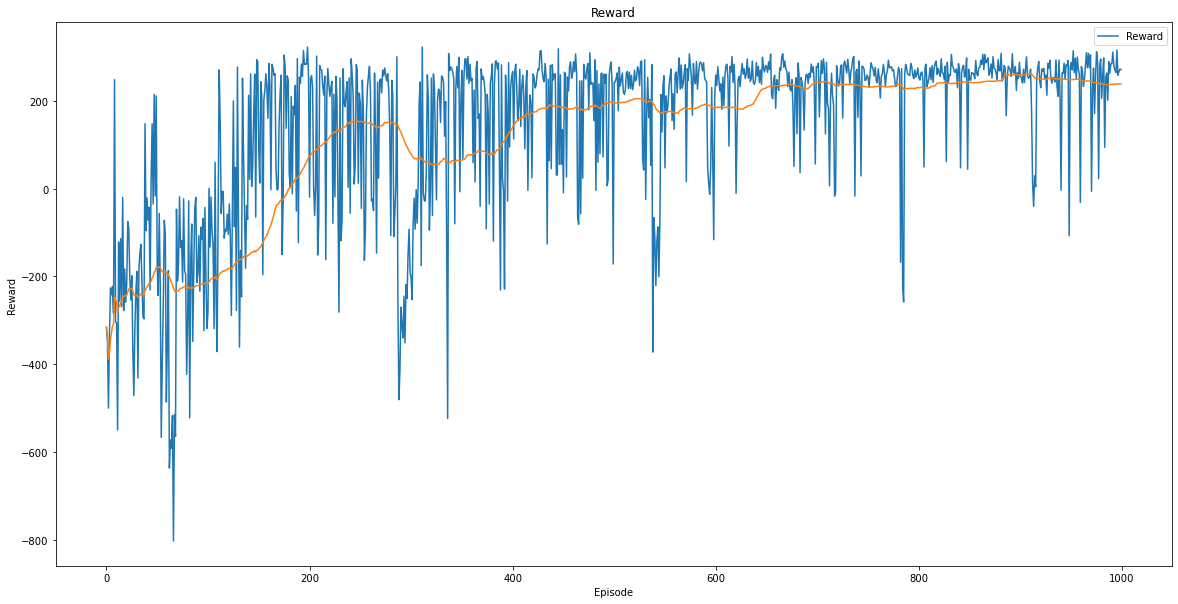

In [4]:


plt.figure(figsize=(20,10))
plt.plot(data['reward'])
plt.plot(data['average'])
plt.title('Reward')
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.legend(['Reward'], loc='best')
plt.show()

In [6]:
trained_model = load_model('./model/ggdp_model.h5') 
evaluation_max_episodes = 10
evaluation_max_steps = 300

rewards = []
for episode in range(1, evaluation_max_episodes + 1):
    state = env.reset()
    state = state.reshape((1, 8))
    state = tf.convert_to_tensor(state)
    episode_reward = 0
    step = 1
    for step in range(1, evaluation_max_steps + 1):
        env.render()
        action = trained_model.predict(state)
        new_state, reward, done, info = env.step(action[0])

        fraction_finished = (step + 1) / evaluation_max_steps
        # new_state = np.append(new_state, fraction_finished)
        new_state = new_state.reshape((1, 8))
        new_state = tf.convert_to_tensor(new_state) 

        episode_reward += reward

        if step == evaluation_max_steps:
            print(f"Episode reached the maximum number of steps. {evaluation_max_steps}")
            done = True

        state = new_state

        if done:
            break

    print(f"episode {episode} finished in {step} steps with reward {episode_reward}.")
    rewards.append(episode_reward)
# print("Average reward: " + np.average(rewards))
env.close()

episode 1 finished in 173 steps with reward 242.83850991004883.
episode 2 finished in 195 steps with reward 280.6558424959344.
episode 3 finished in 174 steps with reward 237.33583028554824.
episode 4 finished in 180 steps with reward 254.10784907244067.
episode 5 finished in 207 steps with reward 291.11042731886124.
Episode reached the maximum number of steps. 300
episode 6 finished in 300 steps with reward 92.52811976508346.
episode 7 finished in 163 steps with reward 252.46278995265143.
episode 8 finished in 168 steps with reward 248.79964463090855.
episode 9 finished in 193 steps with reward 270.4895821122922.
episode 10 finished in 189 steps with reward 285.1654880626137.


In [3]:
# trained_model = load_model('./model/actor_net.h5')
# env = gym.make("LunarLanderContinuous-v2")
from gym import wrappers
trained_model = load_model('./model/ggdp_model.h5') 
evaluation_max_steps = 300

rewards = []
env = wrappers.Monitor(env, "./gym-results", force=True)
random.seed(42)
state = env.reset()
state = state.reshape((1, 8))
state = tf.convert_to_tensor(state)
# img = plt.imshow(env.render(mode='rgb_array'))
episode_reward = 0
step = 1
for step in range(1, evaluation_max_steps + 1):
    # img.set_data(env.render(mode='rgb_array')) # just update the data
    # display.display(plt.gcf())
    # display.clear_output(wait=True)
#     env.render()
    action = trained_model.predict(state)
    new_state, reward, done, info = env.step(action[0])

    fraction_finished = (step + 1) / evaluation_max_steps
    # new_state = np.append(new_state, fraction_finished)
    new_state = new_state.reshape((1, 8))
    new_state = tf.convert_to_tensor(new_state) 

    episode_reward += reward

    if step == evaluation_max_steps:
        print(f"Episode reached the maximum number of steps. {evaluation_max_steps}")
        done = True

    state = new_state

    if done:
        break

print(f"episode finished in {step} steps with reward {episode_reward}.")

C:\Users\akunanbaeva\Anaconda3\envs\kera\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))


episode finished in 190 steps with reward 285.1750912537548.
